# Сегментация покупателей

Цель проекта - посредством данных модели предсказания вероятности снижения покупательской активности клиентов и данных о прибыльности клиентов выделить сегменты покупателей и разработать для них персонализированные предложения. 

Задачи проекта:
* загрузить и изучить данные;
* выполнить предобработку данных;
* выполнить исследовательский анализ данных;
* выполнить корреляционный анализ признаков;
* использовать пайплайны для применения моделей;
* проанализировать значимость признаков;
* сегментировать покупателей;
* проанализировать и описать результаты.

Проект состоит из следующих частей:
* [загрузка и изучение данных](#section1):
    * [загрузка данных](#section2);
    * [изучение данных](#section3);
    * [вывод](#section4);
* [предобработка данных](#section5):
    * [переименование полей](#section6);
    * [выявление аномалий](#section7);
    * [изменение типов данных](#section8)
    * [выявление дубликатов](#section9);
    * [преобразование значений в поля](#section10);
    * [вывод](#section11);
* [исследовательский анализ данных](#section12):
    * [статистический анализ признаков](#section13);
    * [визуализация распределения значений признаков](#section14);
    * [вывод](#section15);
* [объединение данных](#section16);
* [корреляционный анализ признаков](#section17);
* [разработка пайплайна](#section18);
* [анализ важности признаков](#section19);
    * [оценка важности признаков](#section20);
    * [вывод](#section21);    
* [сегментация покупателей](#section22);
* [вывод](#section23).

<a id='section1'></a>
## Загрузка и изучение данных

Обновим версию `sklearn`:

In [1]:
pip install --upgrade scikit-learn

Note: you may need to restart the kernel to use updated packages.


Установим библиотеку `phik`:

In [2]:
pip install phik -q

Note: you may need to restart the kernel to use updated packages.


Установим библиотеку `shap`:

In [3]:
!pip install shap

Загрузим необходимые библиотеки:

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from phik import phik_matrix
from phik.report import plot_correlation_matrix

import shap

Для корректного отображения вещественных чисел скорректируем формат и увеличим количество отображающихся столбцов:

In [5]:
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('future.no_silent_downcasting', True)

Загрузим данные и сохраним их в переменные `customers`, `revenue`, `time` и `profit`:

In [6]:
customers = pd.read_csv(
    'https://code.s3.yandex.net/datasets/market_file.csv',
    sep=','
)

revenue = pd.read_csv(
    'https://code.s3.yandex.net/datasets/market_money.csv',
    sep=','
)

time = pd.read_csv(
    'https://code.s3.yandex.net/datasets/market_time.csv',
    sep=','
)

profit = pd.read_csv(
    'https://code.s3.yandex.net/datasets/money.csv',
    sep=';'
)

<a id='section3'></a>
### Изучение данных

Выведем первые 10 строк датафрейма `customers`:

In [7]:
customers.head(10)

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.40,5,121,0.00,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.40,4,819,0.75,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.90,3,539,0.14,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.20,5,896,0.99,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.10,3,1064,0.94,Товары для детей,3,2,3,2
5,215353,Снизилась,стандартт,да,3.30,4,762,0.26,Домашний текстиль,4,1,1,4
6,215354,Снизилась,стандартт,да,5.10,3,431,0.23,Косметика и аксесуары,2,3,7,2
7,215355,Снизилась,стандартт,нет,4.70,4,284,0.17,Товары для детей,5,1,6,4
8,215356,Снизилась,стандартт,да,4.20,4,192,0.14,Косметика и аксесуары,2,2,1,3
9,215357,Снизилась,стандартт,да,3.90,5,154,0.00,Техника для красоты и здоровья,3,3,9,5


Датафрейм `customers` содержит данные о поведении покупателя на сайте, о коммуникациях с покупателем и о продуктовом поведении покупателя. Получим информацию о датафрейме:

In [8]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

В датафрейме `customers` 1300 записей и 13 полей, 7 полей из которых с типом данных `int64`, 4 поля с типом данных `object` и 2 поля с типом данных `float64`.

Датафрейм содержит следующие поля:
* `id` - идентификатор покупателя в корпоративной базе данных;
* `Покупательская активность` - рассчитанный класс покупательской активности;
* `Тип сервиса` - уровень сервиса;
* `Разрешить сообщать` - информация о том, можно ли присылать покупателю дополнительные предложения о товаре;
* `Маркет_актив_6_мес` - среднемесячное значение маркетинговых коммуникаций компании, которое приходилось на покупателя за последние 6 месяцев;
* `Маркет_актив_тек_мес` - количество маркетинговых коммуникаций в текущем месяце;
* `Длительность` - значение, которое показывает, сколько дней прошло с момента регистрации покупателя на сайте;
* `Акционные_покупки` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев;
* `Популярная_категория` - самая популярная категория товаров у покупателя за последние 6 месяцев;
* `Средний_просмотр_категорий_за_визит` - среднее количество категорий, просмотренных покупателем за визит в течение последнего месяца;
* `Неоплаченные_продукты_штук_квартал` - общее число неоплаченных товаров в корзине за последние 3 месяца;
* `Ошибка_сервиса` - число сбоев, которые коснулись покупателя во время посещения сайта;
* `Страниц_за_визит` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца.

Данные в датафрейме соответствуют описанию. Необходимо изменить наименования полей и убедиться, что в датафрейме отсутстуют явные и неявные дубликаты. Кроме того, тип данных полей `Покупательская активность`, `Тип сервиса` и `Разрешить сообщать` целесообразно изменить на булев.

Выведем первые 10 строк датафрейма `revenue`:

In [9]:
revenue.head(10)

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.00
1,215348,текущий_месяц,"3,293.10"
2,215348,предыдущий_месяц,0.00
3,215349,препредыдущий_месяц,"4,472.00"
4,215349,текущий_месяц,"4,971.60"
5,215349,предыдущий_месяц,"5,216.00"
6,215350,препредыдущий_месяц,"4,826.00"
7,215350,текущий_месяц,"5,058.40"
8,215350,предыдущий_месяц,"5,457.50"
9,215351,текущий_месяц,"6,610.40"


Датафрейм `revenue` содержит данные о выручке, которую получает магазин с покупателя. Выведем информацию о датафрейме:

In [10]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


В датафрейме `revenue` 3900 записей и 3 поля с типами данных `int64`, `object` и `float64`.

Датафрейм содержит следующие поля:
* `id` - идентификатор покупателя в корпоративной базе данных;
* `Период` - название периода, во время которого зафиксировано общее время;
* `Выручка` - сумма выручки за период.

Данные в датафрейме соответствуют описанию. Необходимо изменить наименования полей и убедиться отсутствии явных дубликатов. Также целесообразно трансформировать значения поля `Период` в поля.

Выведем первые 10 строк датафрейма `time`:

In [11]:
time.head(10)

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13
5,215350,предыдцщий_месяц,8
6,215351,текущий_месяц,13
7,215351,предыдцщий_месяц,11
8,215352,текущий_месяц,11
9,215352,предыдцщий_месяц,8


Датафрейм `time` содержит данные о времени, которое покупатель провёл на сайте в течение периода. Выведем информацию о датафрейме:

In [12]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


В датафрейме `time` 2600 записей и 3 поля, 2 из которых с типом данных `int64`, и одно с типом данных `object`.

Датафрейм содержит следующие поля:
* `id` - идентификатор покупателя в корпоративной базе данных;
* `Период` - название периода, во время которого зафиксировано общее время;
* `минут` - сумма выручки за период.

Данные в датафрейме соответствуют описанию. Необходимо изменить наименования полей, убедиться в отсутствии дубликатов и трансформировать значения поля `Период` в поля.

Выведем первые 10 строк датафрейма `profit`:

In [13]:
profit.head(10)

,id,Прибыль
0,215348,"0,98"
1,215349,"4,16"
2,215350,"3,13"
3,215351,"4,87"
4,215352,"4,21"
5,215353,"3,95"
6,215354,"3,62"
7,215355,"5,26"
8,215356,"4,93"
9,215357,"4,66"


Датафрейм `profit` содержит данные данные о среднемесячной прибыли магазина от продаж каждому покупателю за последние 3 месяца. Выведем информацию о датафрейме:

In [14]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       1300 non-null   int64 
 1   Прибыль  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


В датафрейме `profit` 1300 записей и 2 поля с типами данных `int64` и `object`.

Датафрейм содержит следующие поля:
* `id` - идентификатор покупателя в корпоративной базе данных;
* `Прибыль` - значение прибыли.

Данные в датафрейме соответствуют описанию. Необходимо изменить наименование и тип данных поля `Прибыль`, и убедиться в отсутствии дубликатов.

<a id='section4'></a>
### Вывод

Данные для разработки моделей представлены в четырех датафреймах. Перед исследовательским анализом данные необходимо предобработать - изменить наименования полей и типы данных, убедиться, что в датафреймах отсутствуют явные и неявные дубликаты, а также преобразовать значения полей `period` датафреймов `time` и `revenue` в поля.

<a id='section5'></a>
## Предобработка данных

<a id='section6'></a>
### Переименование полей

Изменим наименования полей датафрейма `customers`:

In [15]:
customers = customers.rename(
    columns={
        'Покупательская активность' : 'activity_mark',
        'Тип сервиса' : 'service_type',
        'Разрешить сообщать' : 'permission',
        'Маркет_актив_6_мес' : 'market_com_six_months',
        'Маркет_актив_тек_мес' : 'market_com_cur_month',
        'Длительность' : 'duration',
        'Акционные_покупки' : 'promo_purchases',
        'Популярная_категория' : 'popular_category',
        'Средний_просмотр_категорий_за_визит' : 'avg_view_per_session',
        'Неоплаченные_продукты_штук_квартал' : 'unpaid_items',
        'Ошибка_сервиса' : 'service_error_count',
        'Страниц_за_визит' : 'pages_per_session_count'
    }
)

Убедимся, что поля переименованы - выведем информацию о датафрейме `customers`:

In [16]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1300 non-null   int64  
 1   activity_mark            1300 non-null   object 
 2   service_type             1300 non-null   object 
 3   permission               1300 non-null   object 
 4   market_com_six_months    1300 non-null   float64
 5   market_com_cur_month     1300 non-null   int64  
 6   duration                 1300 non-null   int64  
 7   promo_purchases          1300 non-null   float64
 8   popular_category         1300 non-null   object 
 9   avg_view_per_session     1300 non-null   int64  
 10  unpaid_items             1300 non-null   int64  
 11  service_error_count      1300 non-null   int64  
 12  pages_per_session_count  1300 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 132.2+ KB


Изменим наименования полей датафрейма `revenue`:

In [17]:
revenue = revenue.rename(
    columns={
        'Период' : 'period',
        'Выручка' : 'revenue'
    }
)

Выведем информацию о датафрейме `revenue`:

In [18]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


Изменим наименования полей датафрейма `time`:

In [19]:
time = time.rename(
    columns={
        'Период' : 'period',
        'минут' : 'minutes'
    }
)

Выведем информацию о датафрейме `time`:

In [20]:
time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2600 non-null   int64 
 1   period   2600 non-null   object
 2   minutes  2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


Изменим наименование поля `Прибыль` датафрейма `profit`:

In [21]:
profit = profit.rename(
    columns={
        'Прибыль' : 'profit'
    }
)

Для того, чтобы убедиться, что название поля изменилось, выведем информацию о датафрейме:

In [22]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      1300 non-null   int64 
 1   profit  1300 non-null   object
dtypes: int64(1), object(1)
memory usage: 20.4+ KB


Названия полей в датафреймах изменены, можем двигаться дальше.

<a id='section7'></a>
### Выявление аномалий

Убедимся в отсутствии аномальных значений в категориальных переменных датарфейма `customers`. Проверим поле `activity_mark`:

In [23]:
customers['activity_mark'].unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

Аномалии в поле `activity_mark` отсутствуют. Проверим поле `service_type`:

In [24]:
customers['service_type'].unique()

array(['премиум', 'стандартт', 'стандарт'], dtype=object)

Заменим аномальное значение на корректное:

In [25]:
customers['service_type'] = customers['service_type'].replace('стандартт', 'стандарт')

Убедимся, что аномального значения в поле `service_type` нет:

In [26]:
customers['service_type'].unique()

array(['премиум', 'стандарт'], dtype=object)

Проверим поле `permission`:

In [27]:
customers['permission'].unique()

array(['да', 'нет'], dtype=object)

Аномальных значений в  поле `permission` нет. Проверим поле `popular_category`:

In [28]:
customers['popular_category'].unique()

array(['Товары для детей', 'Домашний текстиль', 'Косметика и аксесуары',
       'Техника для красоты и здоровья', 'Кухонная посуда',
       'Мелкая бытовая техника и электроника'], dtype=object)

Аномальные значения в  поле `popular_category` отсутствуют. Проверим поле `period` датафрейма `revenue`:

In [29]:
revenue['period'].unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

Аномальных значений в поле `period` датафрейма `revenue` не обнаружили. Проверим поле `period` датафрейма `time`:

In [30]:
time['period'].unique()

array(['текущий_месяц', 'предыдцщий_месяц'], dtype=object)

Аномальных значений в поле `period` датафрейма `time` нет. Проверили данные на наличие аномалий и скорректировали выявленные. Можем двигаться дальше.

<a id='section8'></a>
### Изменение типов данных

Изменим тип данных полей `activity_mark`, `service_type`, `permission` на булев, предварительно заменив значения:

In [31]:
for column in ['activity_mark', 'service_type', 'permission']:
    customers[column] = customers[column].replace(
        [
            'Снизилась',
            'стандарт',
            'нет'
        ], 0
    ).replace(
        [
            'Прежний уровень',
            'премиум',
            'да'
        ], 1
    ).astype('bool')

Убедимся, что типы данных скорректированы - выведем информацию о датафрейме:

In [32]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       1300 non-null   int64  
 1   activity_mark            1300 non-null   bool   
 2   service_type             1300 non-null   bool   
 3   permission               1300 non-null   bool   
 4   market_com_six_months    1300 non-null   float64
 5   market_com_cur_month     1300 non-null   int64  
 6   duration                 1300 non-null   int64  
 7   promo_purchases          1300 non-null   float64
 8   popular_category         1300 non-null   object 
 9   avg_view_per_session     1300 non-null   int64  
 10  unpaid_items             1300 non-null   int64  
 11  service_error_count      1300 non-null   int64  
 12  pages_per_session_count  1300 non-null   int64  
dtypes: bool(3), float64(2), int64(7), object(1)
memory usage: 105.5+ KB


Изменим тип данных поля `profit` датафрейма `profit` на `float64`:

In [33]:
profit['profit'] = profit['profit'].str.replace(',', '.').astype('float64')

Выведем информацию о датафрейме `profit`:

In [34]:
profit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


Типы данных скорректировали, можем двигаться дальше.

<a id='section9'></a>
### Выявление дубликатов

Убедимся в отсутствиии явных дубликатов в датафрейме `customers`:

In [35]:
customers.duplicated().sum()

0

Явные дубликаты в датафрейме `customers` отсутствуют, при этом в датафрейме нет таких комбинаций полей, в которых могли бы быть неявные дубликаты. Проверим присутствие дубликатов в датафрейме `time`:

In [36]:
time.duplicated().sum()

0

Дубликатов в датафрейме `time` нет. Проверим присутствие дубликатов в датафрейме `revenue`:

In [37]:
revenue.duplicated().sum()

0

Дубликаты в датафрейме `revenue` отсутствуют. Убедимся в отсутствиии явных в датафрейме `profit`:

In [38]:
profit.duplicated().sum()

0

Дубликатов в датафрейме `profit` нет. Убедились в отсутствии дубликатов, можем двигаться дальше.

<a id='section10'></a>
### Преобразование значений в поля

Преобразуем значения поля `period` датафрейма `revenue` в поля: 

In [39]:
revenue_by_periods = revenue.pivot_table(
    index='id',
    columns='period',
    values='revenue'
).rename_axis(columns=None).reset_index().rename(
    columns={
        'препредыдущий_месяц' : 'month_before_prev_month_rev',
        'предыдущий_месяц' : 'prev_month_rev',
        'текущий_месяц' : 'act_month_rev',
    }
)

Выведем первые 5 строк обновленного датафрейма:

In [40]:
revenue_by_periods.head()

,id,prev_month_rev,month_before_prev_month_rev,act_month_rev
0,215348,0.00,0.00,"3,293.10"
1,215349,"5,216.00","4,472.00","4,971.60"
2,215350,"5,457.50","4,826.00","5,058.40"
3,215351,"6,158.00","4,793.00","6,610.40"
4,215352,"5,807.50","4,594.00","5,872.50"


Преобразуем значения поля `period` датафрейма `time` в поля: 

In [41]:
time_by_periods = time.pivot_table(
    index='id',
    columns='period',
    values='minutes'
).rename_axis(columns=None).reset_index().rename(
    columns={
        'предыдцщий_месяц' : 'prev_month_time',
        'текущий_месяц' : 'act_month_time',
    }
)

Выведем первые 5 строк обновленного датафрейма:

In [42]:
time_by_periods.head()

,id,prev_month_time,act_month_time
0,215348,13.00,14.00
1,215349,12.00,10.00
2,215350,8.00,13.00
3,215351,11.00,13.00
4,215352,8.00,11.00


Преобразовали значения времени и выручки для каждого периода в поля. Можем двигаться дальше.

<a id='section11'></a>
### Вывод

В процессе предобработки данных скорректировали названия полей, выявили и исправили аномалии в категориальных переменных, скорректировали типы данных, убедились в отсутствии дубликатов, преобразовали значения времени и выручки для каждого периода в поля. Можем перейти к исследовательскому анализу данных.

<a id='section12'></a>
## Исследовательский анализ данных

<a id='section13'></a>
### Статистический анализ признаков

Изучим количественные и категориальные признаки датафрейма `customers`. Выведем описание данных полей с количественными признаками:

In [43]:
customers[
    [
        'market_com_six_months',
        'market_com_cur_month',
        'duration',
        'promo_purchases',
        'avg_view_per_session',
        'unpaid_items',
        'service_error_count',
        'pages_per_session_count'
    ]
].describe()

,market_com_six_months,market_com_cur_month,duration,promo_purchases,avg_view_per_session,unpaid_items,service_error_count,pages_per_session_count
count,"1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00","1,300.00"
mean,4.25,4.01,601.90,0.32,3.27,2.84,4.19,8.18
std,1.01,0.70,249.86,0.25,1.36,1.97,1.96,3.98
min,0.90,3.00,110.00,0.00,1.00,0.00,0.00,1.00
25%,3.70,4.00,405.50,0.17,2.00,1.00,3.00,5.00
50%,4.20,4.00,606.00,0.24,3.00,3.00,4.00,8.00
75%,4.90,4.00,806.00,0.30,4.00,4.00,6.00,11.00
max,6.60,5.00,"1,079.00",0.99,6.00,10.00,9.00,20.00


У всех количественных признаков значение медианы незначительно отличается от среднего, значение стандартного отклонения меньше среднего, следовательно, выдающихся значений пренебрежительно мало или такие значения отсутствуют.

Для изучения категориальных признаков воспользуемся функцией `cat_var_describe`:

In [44]:
def cat_var_describe(dataframe, columns):
    tables = []
    for col in columns:
        table = dataframe[col].value_counts().reset_index().rename(
            columns={
                col : 'value'
            }
        ).merge(
            dataframe[col].value_counts(
                normalize=True
            ).reset_index().rename(
                columns={
                    col : 'value',
                    'proportion' : 'share'
                }
            ),
            how='left',
            on='value'
        )
        table.insert(0, 'var', col)
        tables.append(table)
        union_table = pd.concat(
            tables,
            ignore_index = True
        )
    display(union_table)

Выведем описание данных категориальных признаков датафрейма `customers`:

In [45]:
cat_var_describe(
    customers, 
    [
        'activity_mark', 
        'service_type',
        'permission',
        'popular_category'
    ]
)

,var,value,count,share
0,activity_mark,True,802,0.62
1,activity_mark,False,498,0.38
2,service_type,False,924,0.71
3,service_type,True,376,0.29
4,permission,True,962,0.74
5,permission,False,338,0.26
6,popular_category,Товары для детей,330,0.25
7,popular_category,Домашний текстиль,251,0.19
8,popular_category,Косметика и аксесуары,223,0.17
9,popular_category,Техника для красоты и здоровья,184,0.14


По описанию категориальных признаков датафрейма `customers` можем сделать следующие выводы:
* активность снизилась у 38% покупателей;
* 29% клиентов пользуются премиальным сервисом;
* почти три четверти клиентов дали свое согласие на получение дополнительных предложений о товарах;
* наиболее популярная категория - товары для детей.

Исключим из датафрейма `revenue_by_periods` покупателей с активностью менее 3 месяцев:

In [46]:
revenue_by_periods = revenue_by_periods.query(
    'prev_month_rev > 0 & month_before_prev_month_rev > 0'
)

Выведем описание данных полей `prev_month_rev`, `act_month_rev` и `month_before_prev_month_rev` датафрейма `revenue_by_periods`:

In [47]:
revenue_by_periods[
    [
        'prev_month_rev',
        'act_month_rev',
        'month_before_prev_month_rev'
    ]
].describe()

,prev_month_rev,act_month_rev,month_before_prev_month_rev
count,"1,297.00","1,297.00","1,297.00"
mean,"4,948.34","5,316.45","4,836.37"
std,701.23,"2,942.47",333.44
min,"2,890.00","2,758.70","4,098.00"
25%,"4,498.50","4,706.60","4,585.00"
50%,"5,005.50","5,180.30","4,812.00"
75%,"5,409.00","5,761.30","5,055.00"
max,"6,869.50","106,862.20","5,663.00"


Средние значения близки к медианам, значения стандартного отклонения меньше среднего - выдающихся значений нет или их немного. При этом по максимальному значению поля `act_month_rev` очевидно, что такие выдающиеся значения присутствуют в этом поле.

Выведем описание данных полей `prev_month_time` и `act_month_time` датафрейма `time_by_periods`:

In [48]:
time_by_periods[
    [
        'prev_month_time',
        'act_month_time'
    ]
].describe()

,prev_month_time,act_month_time
count,"1,300.00","1,300.00"
mean,13.47,13.20
std,3.93,4.22
min,5.00,4.00
25%,11.00,10.00
50%,13.00,13.00
75%,17.00,16.00
max,23.00,23.00


По средним и медианам, которые отличаются незначительно, а также по значениям стандартного отклонения, которые меньше средних, можно сделать вывод, что выдающиеся значения отсутствуют.

Выведем описание данных поля `profit` датафрейма `profit`:

In [49]:
profit['profit'].describe()

count   1,300.00
mean        4.00
std         1.01
min         0.86
25%         3.30
50%         4.04
75%         4.67
max         7.43
Name: profit, dtype: float64

Выдающихся значений в поле `profit` датафрейма `profit` нет.

<a id='section14'></a>
### Визуализация распределения значений признаков

Для визуализации распределения значений количественных признаков воспользуемся функцией `quant_var_plot`:

In [50]:
def quant_var_plot(dataframe, columns):
    
    ncols = 2
    nrows = np.ceil(
        np.divide(
            len(columns),
            ncols
        )
    ).astype('int')

    plt.figure(figsize=(20, 20))

    for n, col in enumerate(columns):
        ax = plt.subplot(nrows, ncols, n + 1)
        sns.histplot(
            x=dataframe[col],
            bins=len(
                dataframe[col].unique()
            ),
            element='step',
            fill=False,
            ax=ax
        )

Визуализируем распределения значений количественных признаков датафрейма `customers`:

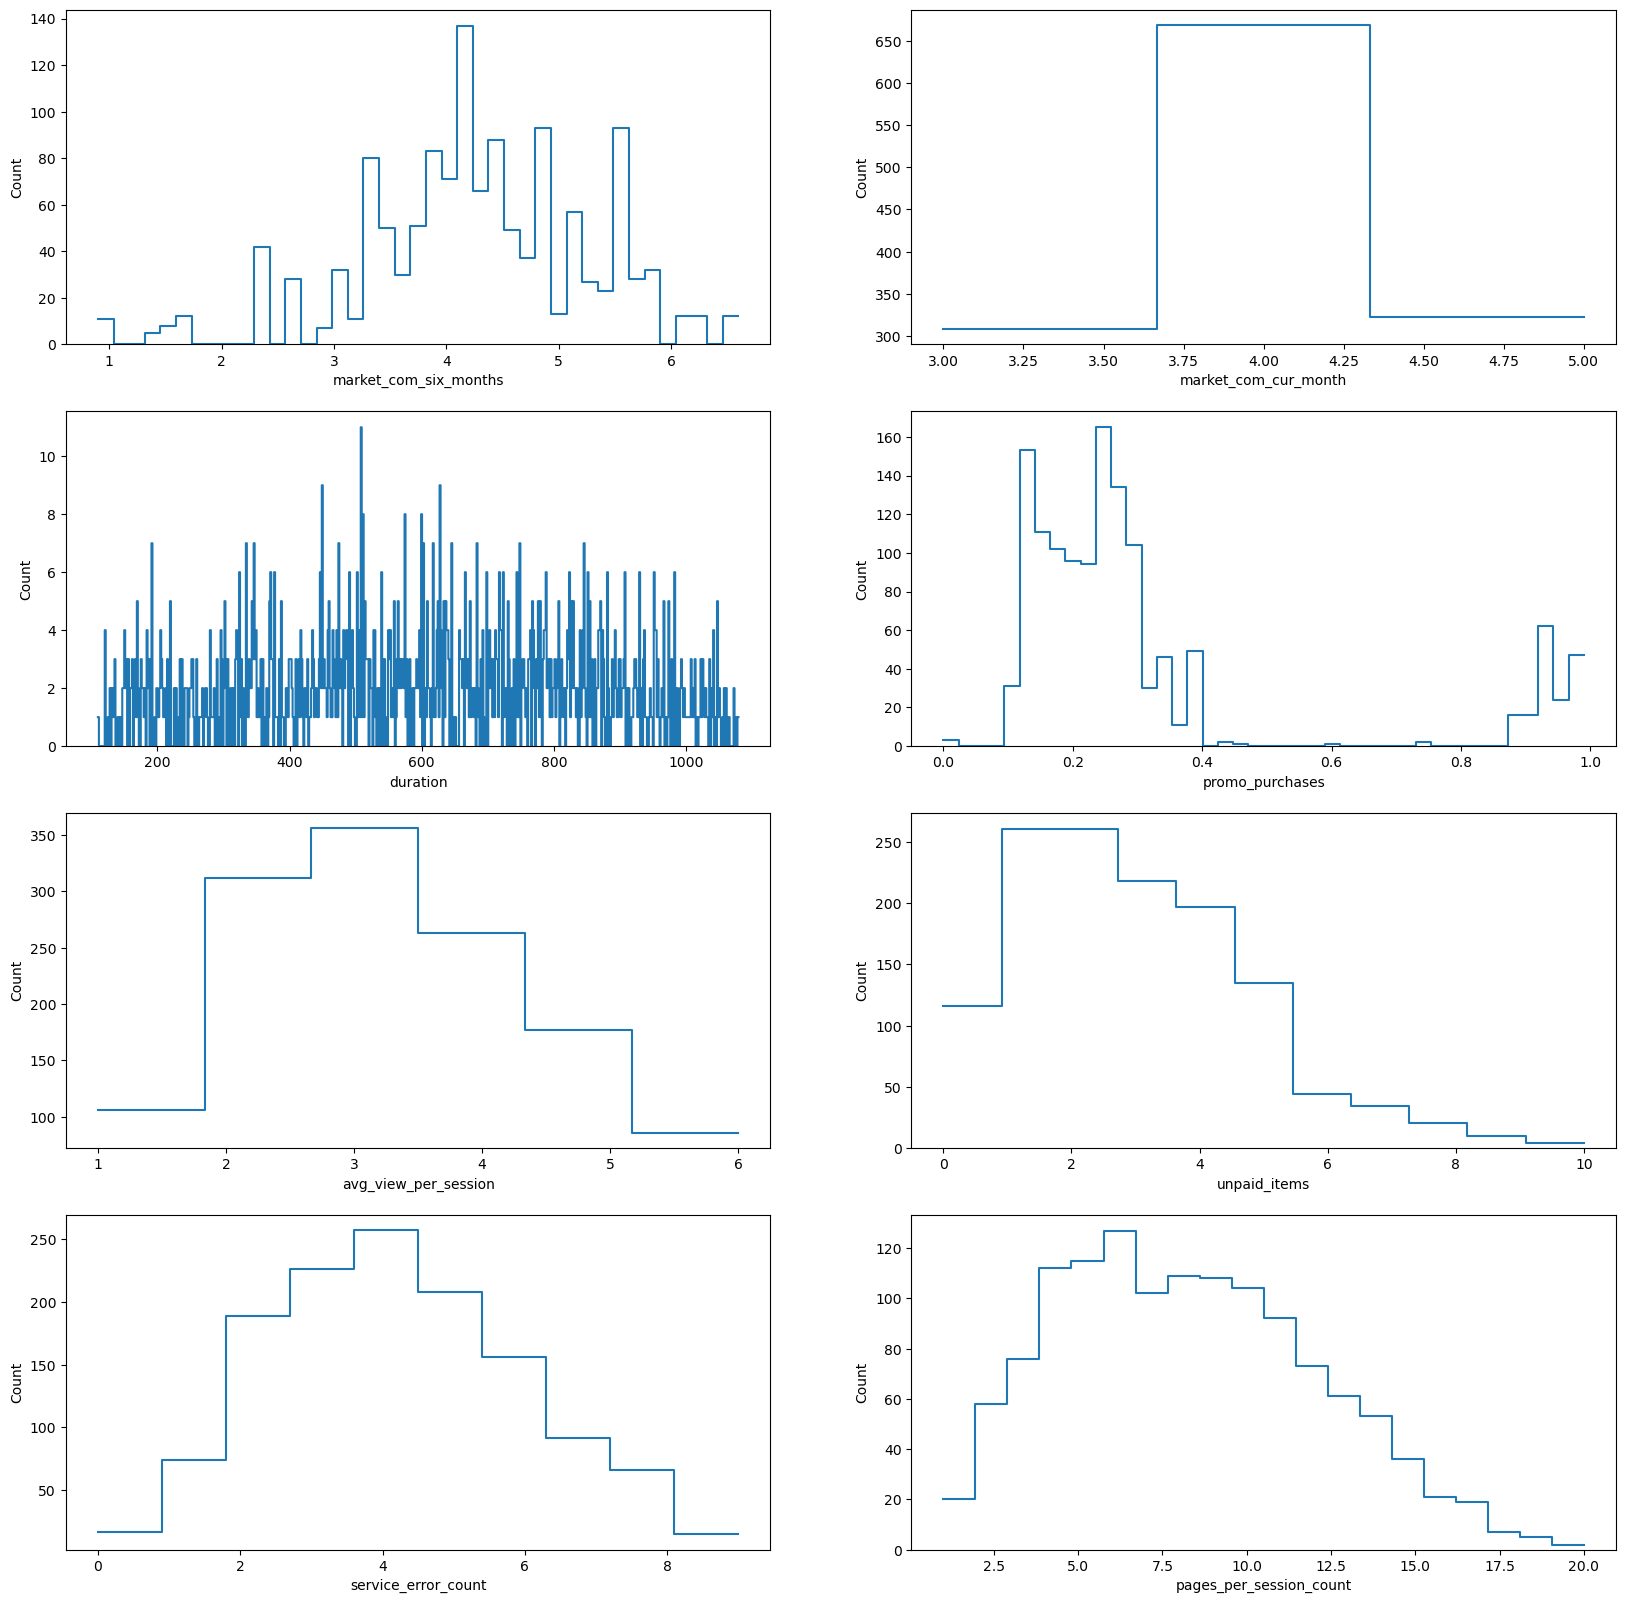

In [51]:
quant_var_plot(
    customers,
    [
        'market_com_six_months',
        'market_com_cur_month',
        'duration',
        'promo_purchases',
        'avg_view_per_session',
        'unpaid_items',
        'service_error_count',
        'pages_per_session_count'
    ]
)

По графикам очевидно, что признаки `market_com_cur_month` и `promo_purchases` можно преобразовать в категориальные.

Для визуализации распределения значений категориальных признаков воспользуемся функцией `cat_var_plot`:

In [52]:
def cat_var_plot(dataframe, columns):

    ncols = 2
    nrows = np.ceil(
        np.divide(
            len(columns),
            ncols
        )
    ).astype('int')

    plt.figure(figsize=(20, 20))

    for n, col in enumerate(columns):
        ax = plt.subplot(nrows, ncols, n + 1)
        ax.pie(
            x=dataframe[col].value_counts(
                normalize=True
            ).reset_index().rename(
                columns={
                    col : 'value',
                    'proportion' : 'share'
                }
            )['share'],
            autopct='%.1f%%',
            explode=[0.05]*(len(dataframe[col].unique())),
            labels=dataframe[col].value_counts(
                normalize=True
            ).reset_index().rename(
                columns={
                    col : 'value',
                    'proportion' : 'share'
                }
            )['value'],
            pctdistance=0.5
        )
        ax.set(
            aspect="equal", 
            title=col
        )

In [88]:
[0.05]*(len(customers['popular_category'].unique()))

[0.05, 0.05, 0.05, 0.05, 0.05, 0.05]

Визуализируем распределение категориальных признаков датафрейма `customers`:

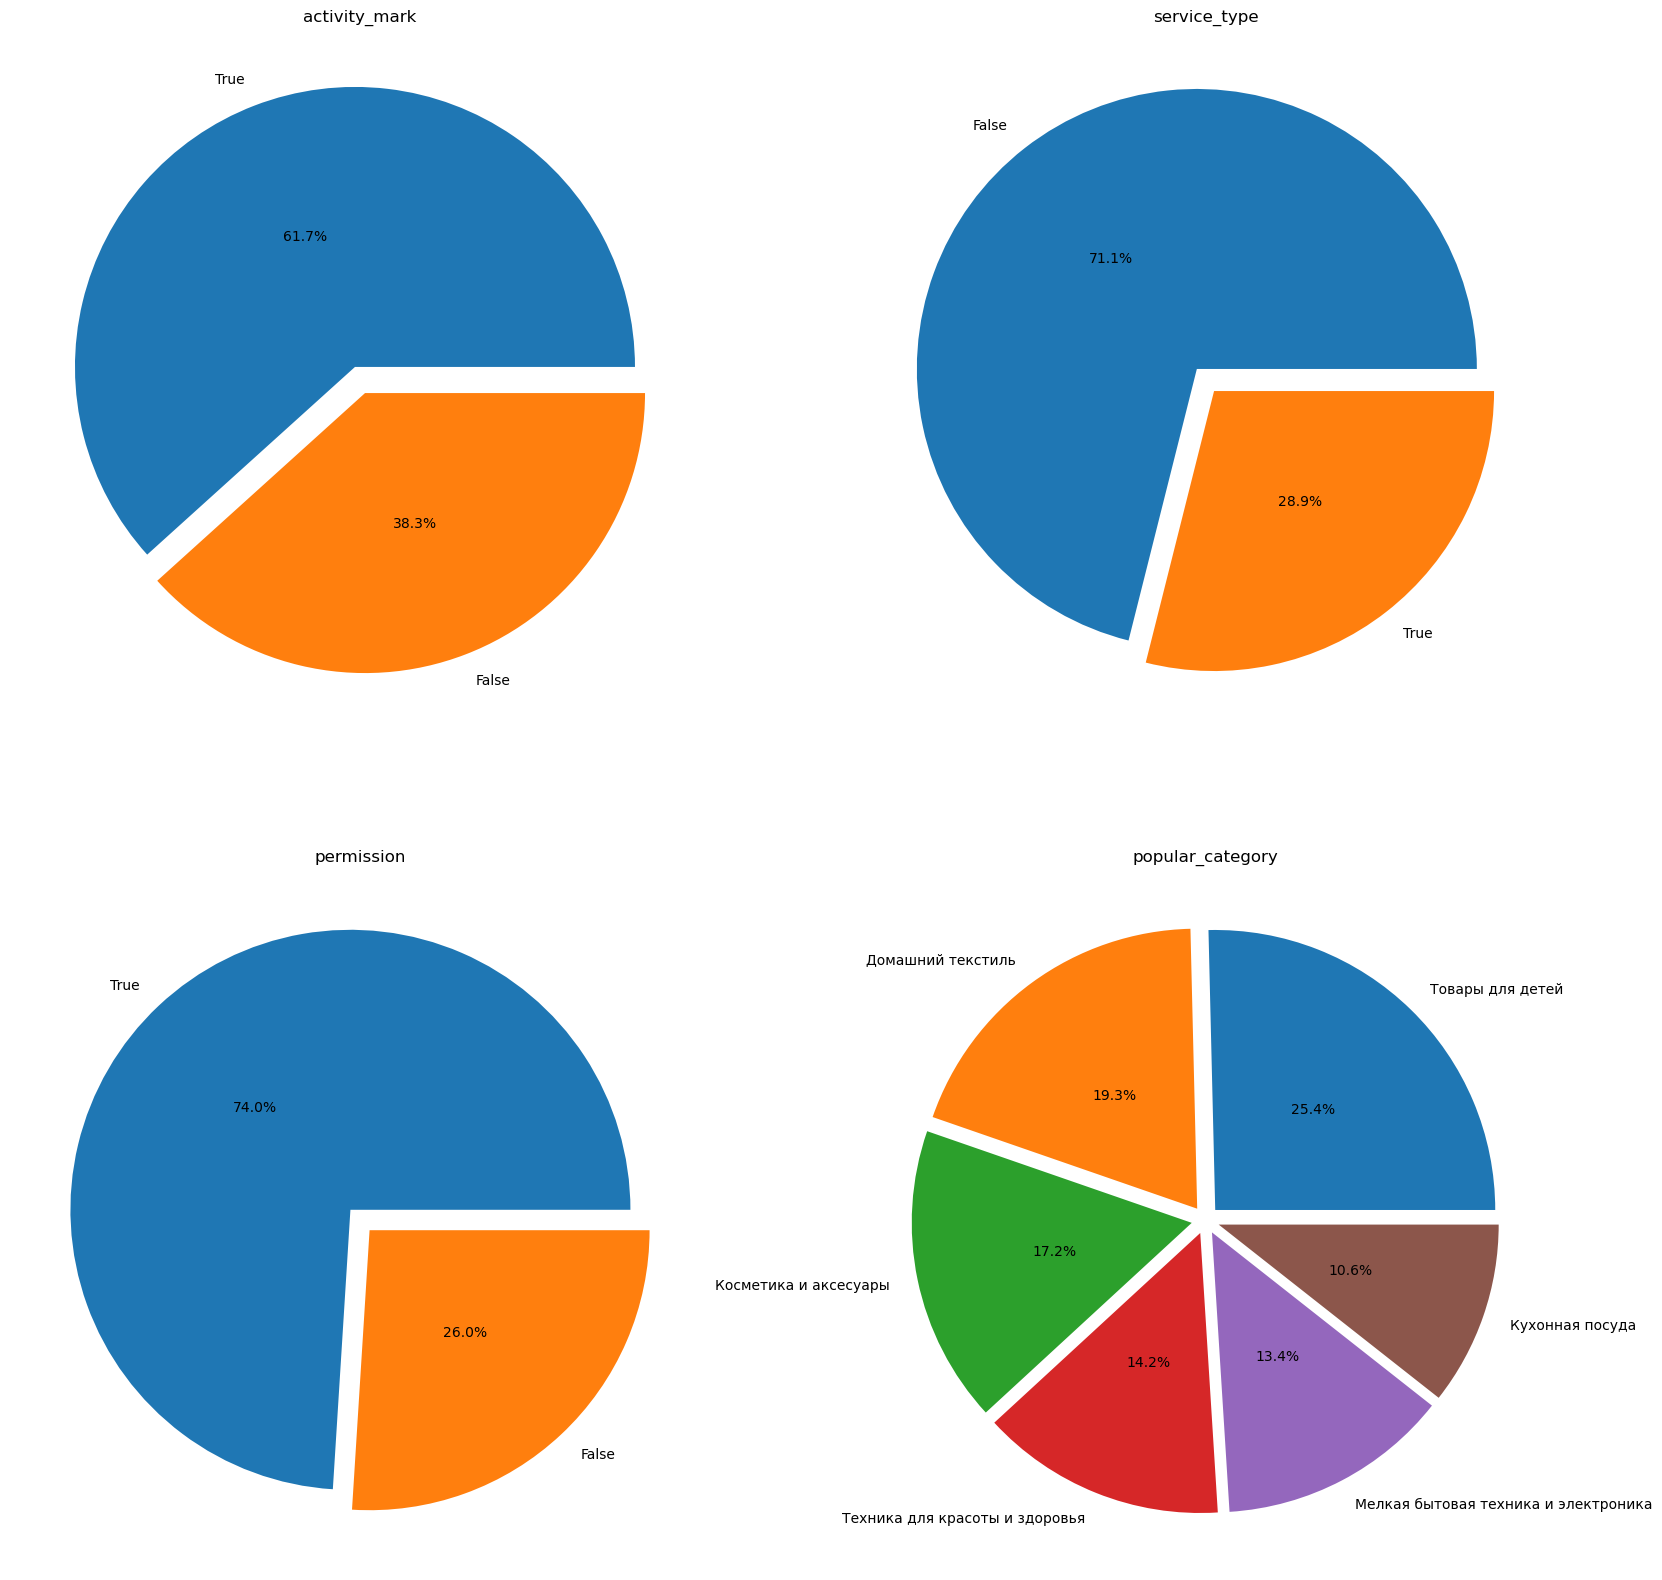

In [53]:
cat_var_plot(
    customers, 
    [ 
        'activity_mark',
        'service_type',
        'permission',
        'popular_category'
    ]
)

По диаграмме распределения классов целевого признака `activity_mark` очевиден дисбаланс классов. Визуализируем распределение признаков `previous_month`, `actual_month` и `month_before_previous_month` датафрейма `revenue_by_periods`:

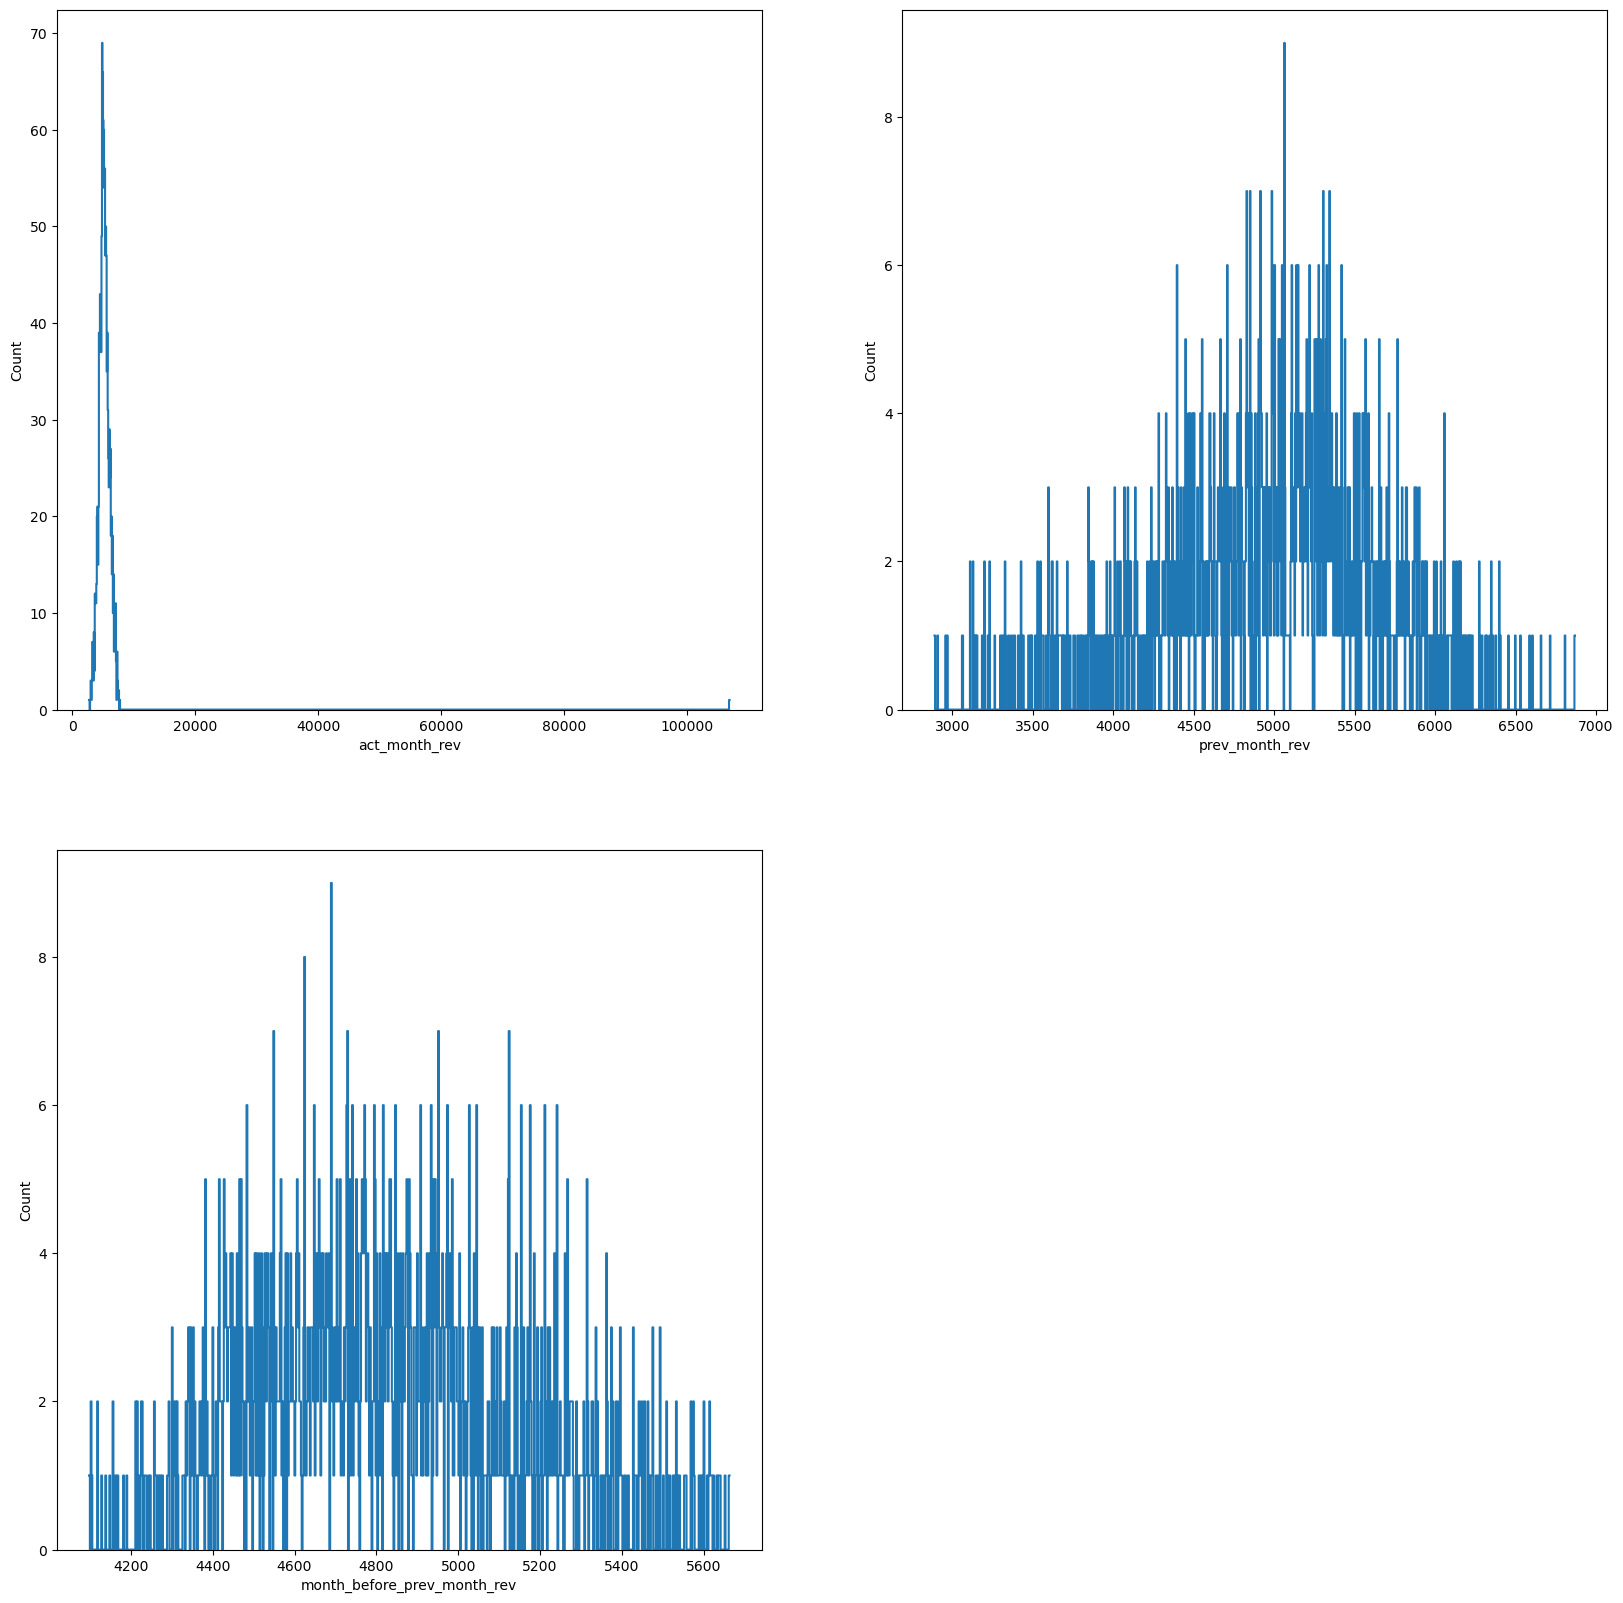

In [54]:
quant_var_plot(
    revenue_by_periods,
    [
        'act_month_rev',
        'prev_month_rev',
        'month_before_prev_month_rev'
    ]
)

В поле `actual_month` очевидно выдающиеся значение. Удалим клиента с таким значением из датафрейма: 

In [55]:
revenue_by_periods = revenue_by_periods[revenue_by_periods['act_month_rev'] != revenue_by_periods['act_month_rev'].max()]

Визуализируем распределение признаков `prev_month` и `act_month` датафрейма `time_by_periods`:

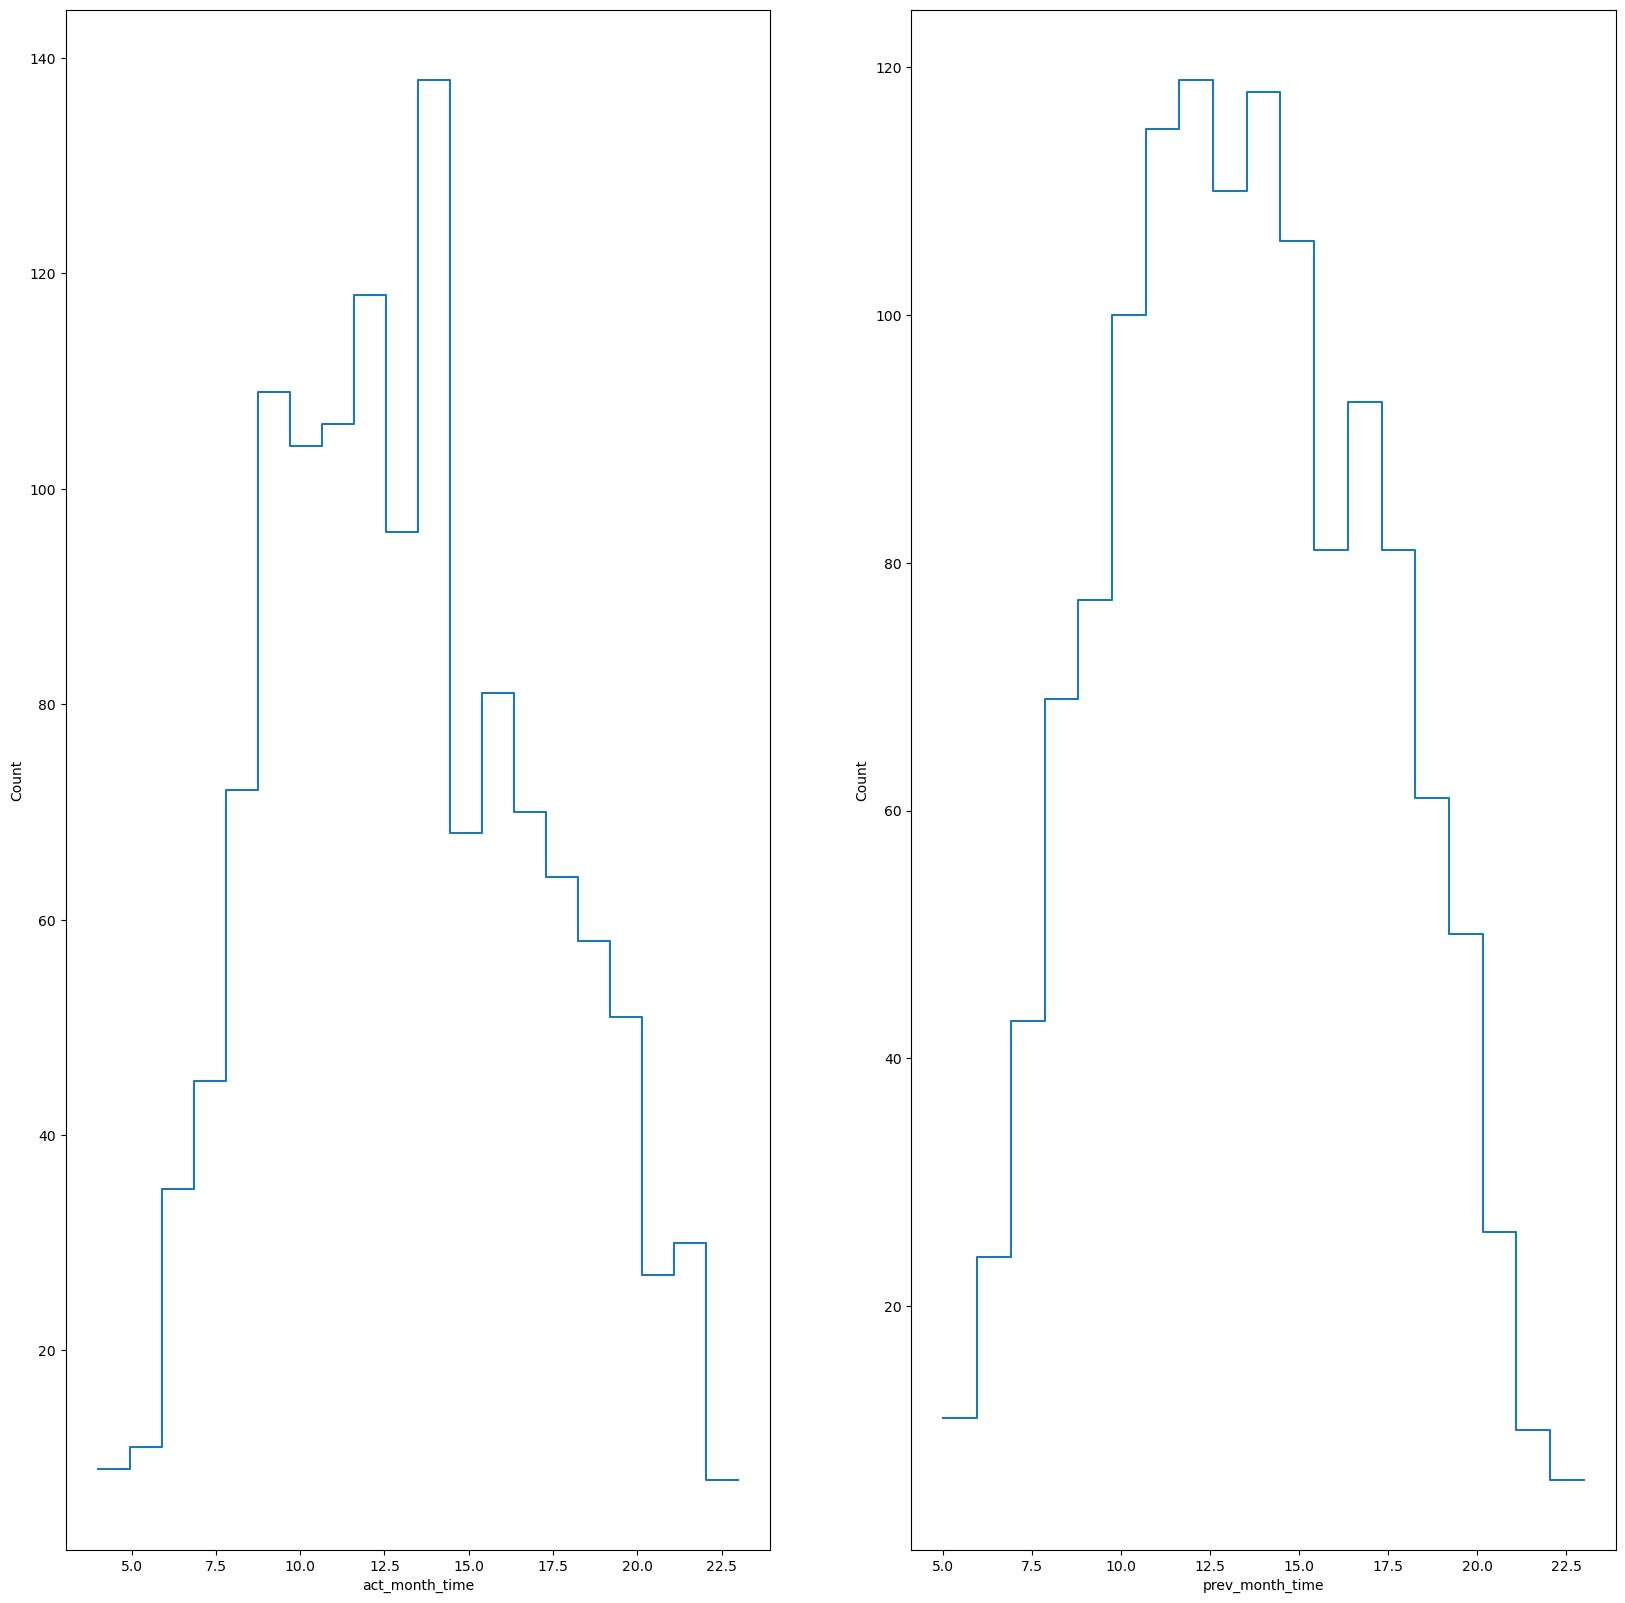

In [56]:
quant_var_plot(
    time_by_periods,
    [
        'act_month_time',
        'prev_month_time'
    ]
)

Гистограммы напоминают графики нормального распределения. Визуализируем распределение признака `profit` датафрейма `profit`:

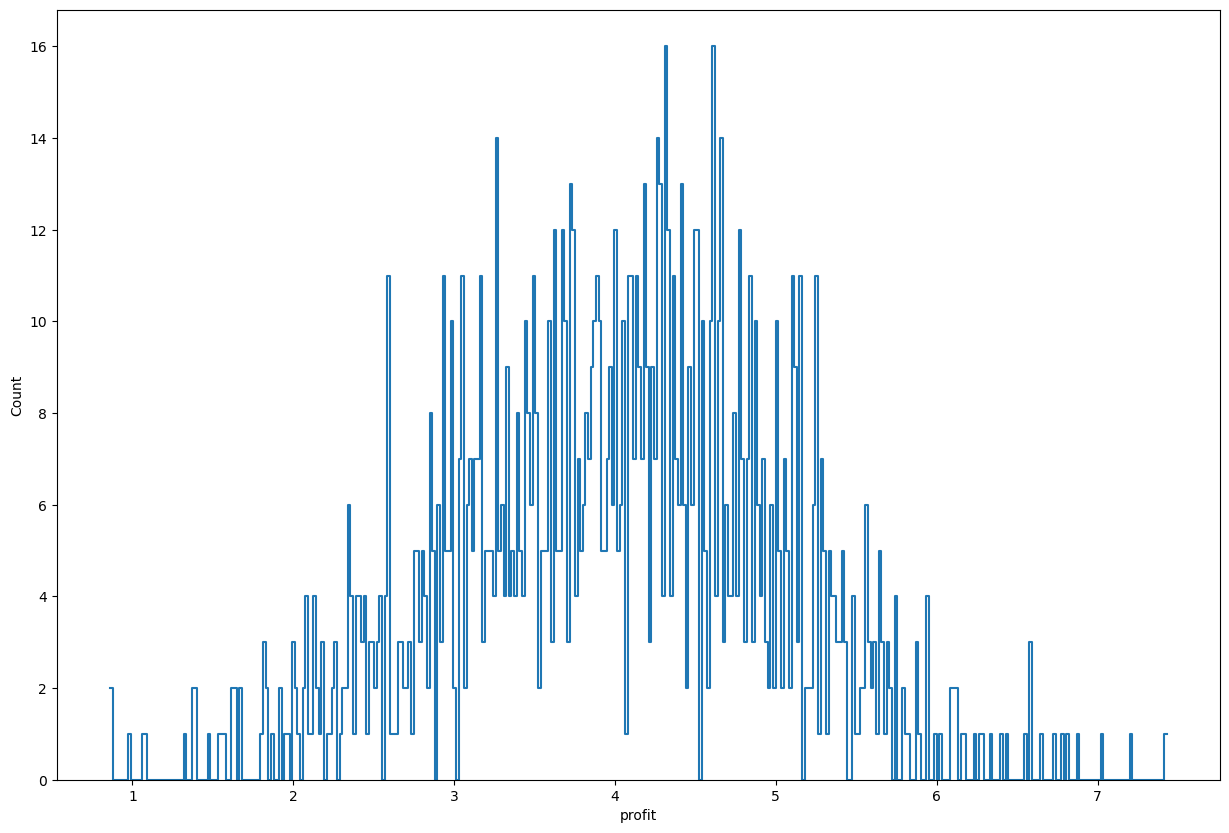

In [57]:
plt.figure(figsize=(15,10))

sns.histplot(
    x=profit['profit'],
    bins=len(
        profit['profit'].unique()
    ),
    element='step',
    fill=False
)

plt.show()

Визуализация распределения значений признака `profit` датафрейма `profit` подтверждает выводы, полученные на этапе статистического анализа. 

<a id='section15'></a>
### Вывод

В результате исследовательского анализа данных можем сделать следующие выводы:
* очевиден дисбаланс классов целевого признака;
* признаки `market_com_cur_month` и `promo_purchases` можно преобразовать в категориальные;
* в признаке `actual_month` датафрейма `revenue_by_periods` присутствовало выдающиеся значение, клиента с таким значением удалили из датафрейма;
* кроме того, исключили из датафрейма `revenue_by_periods` покупателей с покупательской активностью менее 3 месяцев.

Можем переходить к объединению данных.

<a id='section16'></a>
## Объединение данных

Объединим для моделирования датафреймы `customers`, `revenue_by_periods` и `time_by_periods`:

In [58]:
target_df = customers.merge(
    revenue_by_periods,
    on='id',
    how='inner'
).merge(
    time_by_periods,
    on='id',
    how='inner'
)

Выведем первые 10 строк объединенного датафрейма:

In [59]:
target_df.head(10)

,id,activity_mark,service_type,permission,market_com_six_months,market_com_cur_month,duration,promo_purchases,popular_category,avg_view_per_session,unpaid_items,service_error_count,pages_per_session_count,prev_month_rev,month_before_prev_month_rev,act_month_rev,prev_month_time,act_month_time
0,215349,False,True,True,4.40,4,819,0.75,Товары для детей,4,4,2,5,"5,216.00","4,472.00","4,971.60",12.00,10.00
1,215350,False,False,False,4.90,3,539,0.14,Домашний текстиль,5,2,1,5,"5,457.50","4,826.00","5,058.40",8.00,13.00
2,215351,False,False,True,3.20,5,896,0.99,Товары для детей,5,0,6,4,"6,158.00","4,793.00","6,610.40",11.00,13.00
3,215352,False,False,False,5.10,3,1064,0.94,Товары для детей,3,2,3,2,"5,807.50","4,594.00","5,872.50",8.00,11.00
4,215353,False,False,True,3.30,4,762,0.26,Домашний текстиль,4,1,1,4,"4,738.50","5,124.00","5,388.50",10.00,10.00
5,215354,False,False,True,5.10,3,431,0.23,Косметика и аксесуары,2,3,7,2,"5,685.00","4,503.00","5,869.60",11.00,12.00
6,215355,False,False,False,4.70,4,284,0.17,Товары для детей,5,1,6,4,"3,263.00","4,749.00","3,772.60",12.00,10.00
7,215356,False,False,True,4.20,4,192,0.14,Косметика и аксесуары,2,2,1,3,"4,146.50","4,433.00","4,566.40",6.00,7.00
8,215358,False,False,True,4.70,4,450,0.13,Домашний текстиль,4,2,6,4,"3,488.00","4,727.00","4,209.50",14.00,10.00
9,215360,False,True,True,3.90,3,623,0.35,Кухонная посуда,3,1,4,7,"5,304.50","5,555.00","5,834.90",9.00,6.00


Получим информацию о датафрейме:

In [60]:
target_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1296 non-null   int64  
 1   activity_mark                1296 non-null   bool   
 2   service_type                 1296 non-null   bool   
 3   permission                   1296 non-null   bool   
 4   market_com_six_months        1296 non-null   float64
 5   market_com_cur_month         1296 non-null   int64  
 6   duration                     1296 non-null   int64  
 7   promo_purchases              1296 non-null   float64
 8   popular_category             1296 non-null   object 
 9   avg_view_per_session         1296 non-null   int64  
 10  unpaid_items                 1296 non-null   int64  
 11  service_error_count          1296 non-null   int64  
 12  pages_per_session_count      1296 non-null   int64  
 13  prev_month_rev    

Количество идентификаторов клиентов в объединном датафрейме соответствует количеству идентификаторов в датафрейме `revenue_by_periods`, пропущенных значений нет. Можем переходить к корреляционному анализу признаков.

<a id='section17'></a>
## Корреляционный анализ признаков

Создадим список с наименованиями количественных признаков:

In [61]:
interval_columns = target_df.drop(
    [
        'id',
        'activity_mark',
        'service_type',
        'permission',
        'popular_category'
    ],
    axis=1   
).columns

Рассчитаем корреляции:

In [62]:
overview = phik_matrix(
    target_df.drop(
        [
            'id'
        ],
        axis=1 
    ),
    interval_cols=interval_columns
)

Визуализируем матрицу корреляции:

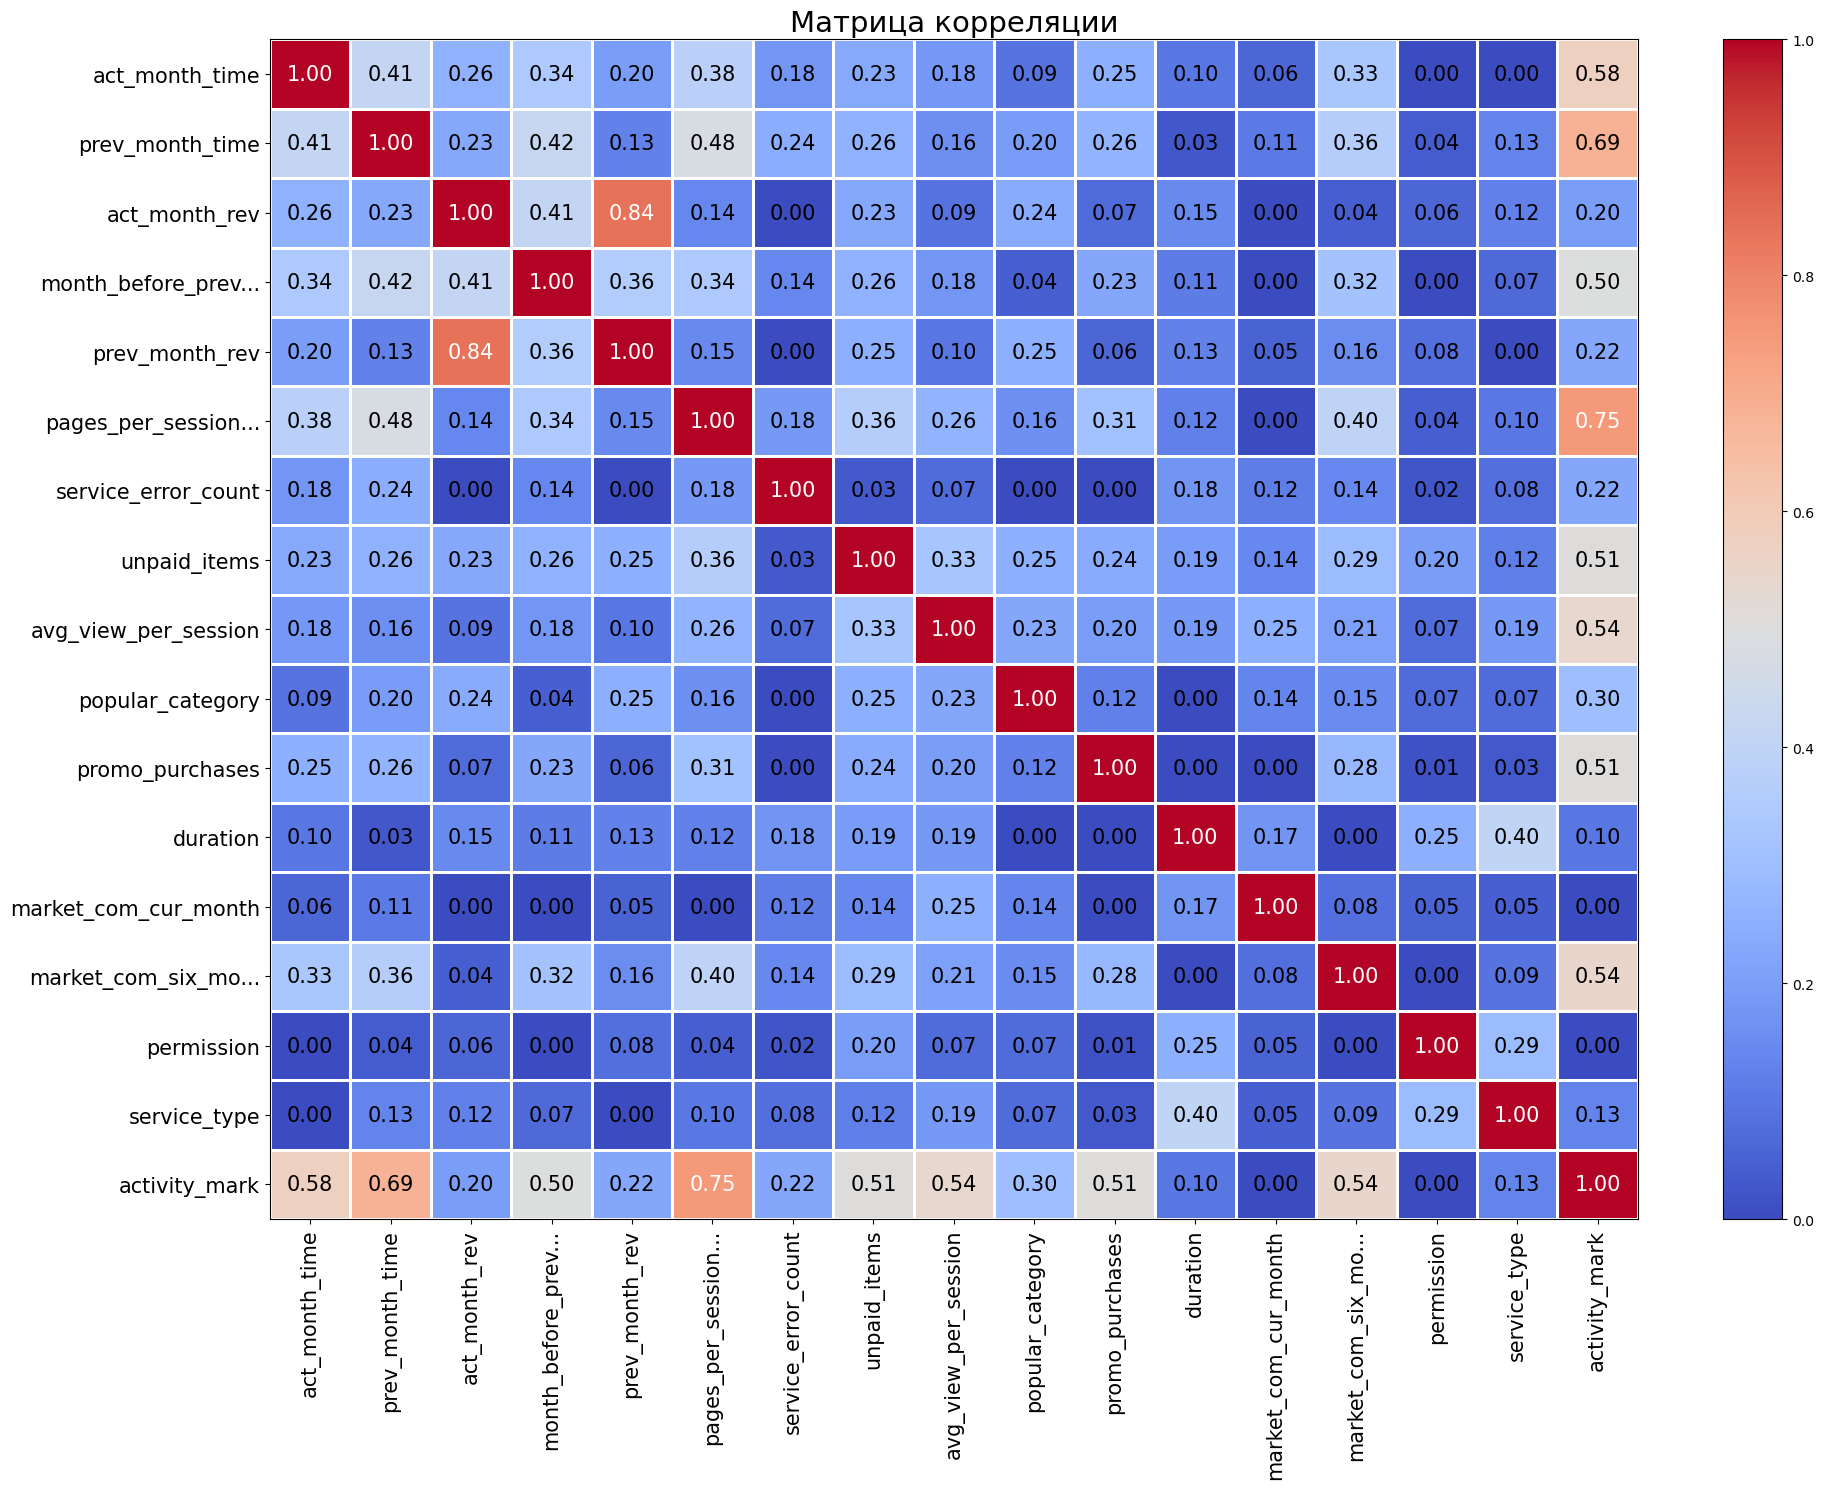

In [63]:
plot_correlation_matrix(
    overview.values,
    x_labels=overview.columns,
    y_labels=overview.index,
    vmin=0, 
    vmax=1, 
    color_map='coolwarm',
    title=('Матрица корреляции'),
    fontsize_factor=1.5,
    figsize=(20, 15)
)

По матрице корреляции можно сделать следующие выводы:
* мультиколлинеарность отсутствует;
* выявлена высокая корреляция между целевым признаком и признаком `pages_per_session_count`;
* выявлена заметная корреляция между целевым признаком и признаками `act_month_time`, `prev_month_time`, `month_before_prev_month_rev`, `unpaid_items`, `avg_view_per_session`, `promo_purchases` и `market_com_six_months`;
* выявлена высокая корреляция между признаками `prev_month_rev` и `act_month_rev`.

Корреляционный анализ признаков выполнили, можем переходить к разработке пайплайна.

<a id='section18'></a>
## Разработка пайплайна

Для выбора лучшей модели предсказания вероятности снижения покупательской активности воспользуемся пайплайном, при этом для всех моделей будем использовать один пайплайн и один иструмент подбора гиперпараметров. Лучшую модель выберем между `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и `SVC()`, для подбора гиперпараметров воспользуемся `RandomizedSearchCV`. Для оценки лучшей модели будем использовать метрику `ROC-AUC`, так как выявили дисбаланс классов значений целевого признака.

Установим поле с индентификаторами клиентов идексом датафрейма `target_df`:

In [64]:
target_df = target_df.set_index('id')

Установим константы:

In [65]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

Разделим данные на тренировочную и тестовую выборки:

In [66]:
X_train, X_test, y_train, y_test = train_test_split(
    target_df.drop(
        'activity_mark',
        axis=1
    ),
    target_df['activity_mark'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=target_df['activity_mark']
)

Проверим размерности выборок:

In [67]:
display(X_train.shape)
display(X_test.shape)

(972, 16)

(324, 16)

Создадим списки с названиями признаков:

In [68]:
ohe_columns = [
    'permission', 
    'popular_category'
]

ord_column = ['service_type']


num_columns = [
    'market_com_six_months',
    'market_com_cur_month',
    'duration',
    'promo_purchases',
    'avg_view_per_session',
    'unpaid_items',
    'service_error_count',
    'pages_per_session_count',
    'prev_month_rev',
    'month_before_prev_month_rev',
    'act_month_rev',
    'prev_month_time',
    'act_month_time'
]

Создадим пайплайн для подготовки данных:

In [69]:
data_preprocessor = ColumnTransformer(
    [
        (
            'ohe', 
            OneHotEncoder(
                drop='first',
                sparse_output=False,
                handle_unknown='ignore'
            ),
            ohe_columns
        ),
        (
            'ord',
            OrdinalEncoder(
                categories=[
                    [
                        False,
                        True
                    ]
                ]
            ),
            ord_column
        ),
        (
            'num',
            StandardScaler(),
            num_columns
        )
    ],
    remainder='passthrough'
)

Создадим итоговый пайплайн:

In [70]:
final_pipe = Pipeline(
    [
        (
            'preprocessor',
            data_preprocessor
        ),
        (
            'models',
            DecisionTreeClassifier(
            random_state=42
            )
        )
    ]
    
)
param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [
            DecisionTreeClassifier(
                random_state=RANDOM_STATE
            )
        ],
        'models__max_depth': range(2,4), #изменение для первого коммита
        'models__max_features': range(2,6),
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ]
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [
            KNeighborsClassifier()
        ],
        'models__n_neighbors': range(2,6),
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ]
    },

    # словарь для модели LogisticRegression()
    {
        'models': [
            LogisticRegression(
                random_state=RANDOM_STATE, 
                solver='liblinear', 
                penalty='l1'
            )
        ],
        'models__C': range(1,6),
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ]
    },

    # словарь для модели SVC()
    {
        'models': [
            SVC(
                kernel = 'poly', 
                degree = 4
            )
        ],
        'preprocessor__num': [
            StandardScaler(),
            MinMaxScaler(),
            RobustScaler(),
            'passthrough'
        ] 
    }
]

randomized_search = RandomizedSearchCV(
    final_pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

Создадим экземпляр класса `LabelEncoder` для кодирования целевого признака:

In [71]:
label_encoder = LabelEncoder()

Трансформируем целевую и тестовую выборки:

In [72]:
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

Обучим модели:

In [73]:
randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               OneHotEncoder(drop='first',
                                                                                             handle_unknown='ignore',
                                                                                             sparse_output=False),
                                                                               ['permission',
                                                                                'popular_category']),
                                                                              ('ord',
                                                                               OrdinalEncoder(categories=[[False,
                                                                                                           True]]),
                                                                               ['service_type']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['market_com_six_months...
                                                               'passthrough']},
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(degree=4,
                                                        kernel='poly')],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               RobustScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

Рассчитаем прогноз на тестовых данных:

In [74]:
y_test_pred = randomized_search.predict(X_test)

Выведем метрику лучшей модели на тестовой выборке:

In [75]:
print('Метрика лучшей модели на тренировочной выборке:', randomized_search.best_score_)

Метрика лучшей модели на тренировочной выборке: 0.9050370411734047


Рассчитаем и выведем значение метрики `ROC-AUC` на тестовой выборке:

In [76]:
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_test, y_test_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.8334677419354839


Значение метрики `ROC-AUC` на тестовой выборке составило 0,835, что свидтельствует о высоком качестве модели. Выведем параметры лучшей модели:

In [77]:
randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__C': 4,
 'models': LogisticRegression(penalty='l1', random_state=42, solver='liblinear')}

Лучшей моделью оказалась модель линейной регрессии со скалером `MinMaxScaler`. Получили предсказания и лучшую модель, можем переходить к анализу важности признаков.

<a id='section19'></a>
## Анализ важности признаков

<a id='section20'></a>
### Оценка важности признаков

Проанализируем оценки значимости признаков. Построим график общей значимости признаков:

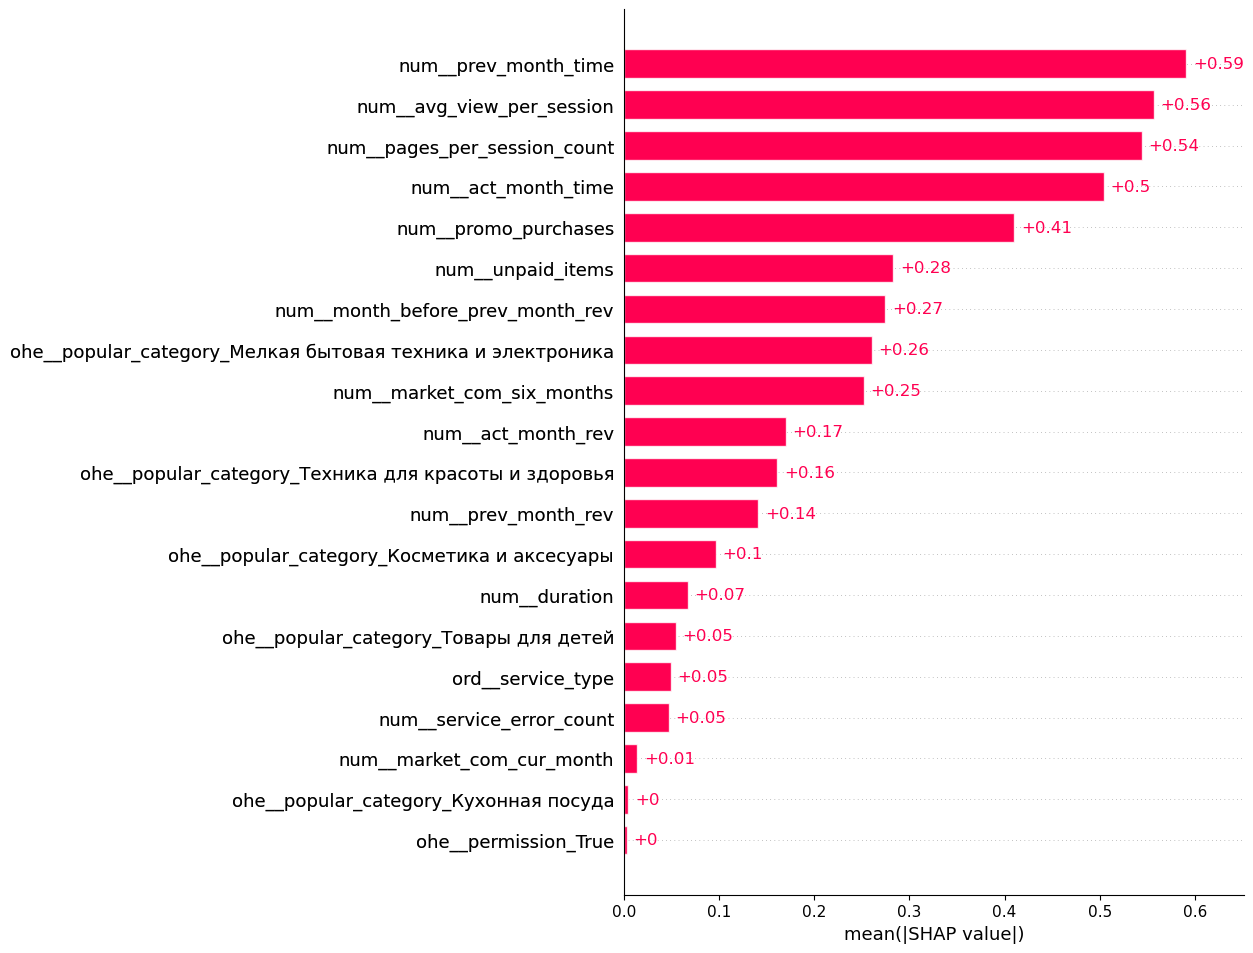

In [78]:
X_train_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].fit_transform(X_train)
X_test_transformed = randomized_search.best_estimator_.named_steps['preprocessor'].transform(X_test)
explainer = shap.LinearExplainer(
    randomized_search.best_estimator_.named_steps['models'],
    X_train_transformed,
    feature_names=randomized_search.best_estimator_.named_steps['preprocessor'].get_feature_names_out()
)
shap_values = explainer(X_test_transformed)
shap.plots.bar(shap_values, max_display=20) 

Наиболее значимые признаки для модели - время, которое покупатель провел на сайте в предыдущем месяце `prev_month_time`, среднее количество просмотров категорий за визит `avg_view_per_session` и среднее количество просмотренных страниц за визит `pages_per_session_count`. Наименее значимые признаки - согласие о получении дополнительных предложений о товаре `permission`, значение `Кухонная посуда` признака самой популярной категории товаров `popular_category` и количество маркетинговых коммуникаций в текущем месяце `market_com_cur_month`.

Определим влияние признаков на каждое предсказание модели:

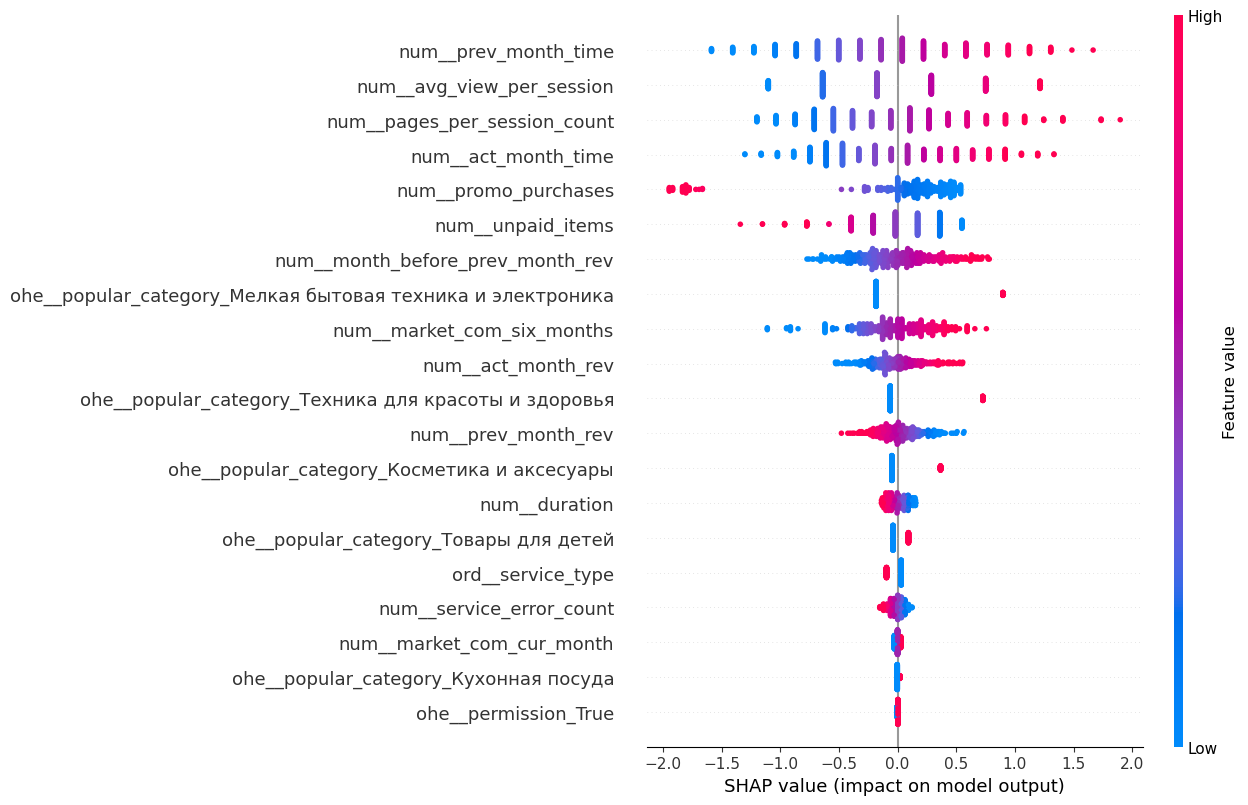

In [79]:
shap.plots.beeswarm(shap_values, max_display=20)

Наиболее значимые для модели признаки в равной степени влияют на вероятность принадлежности клиента как к группе оттока, так и к группе постоянных покупателей. Изучим распределение наиболее значимых признаков в зависимости от группы клиентов. Для этого на основе тестовой выборки создадим датафрейм с предсказанными значениями целевого признака: 

In [80]:
final_df = X_test.reset_index()
final_df['activity_mark_pred'] = randomized_search.predict(X_test)

Визуализируем распределения наиболее значимых признаков в зависимости от группы клиентов:

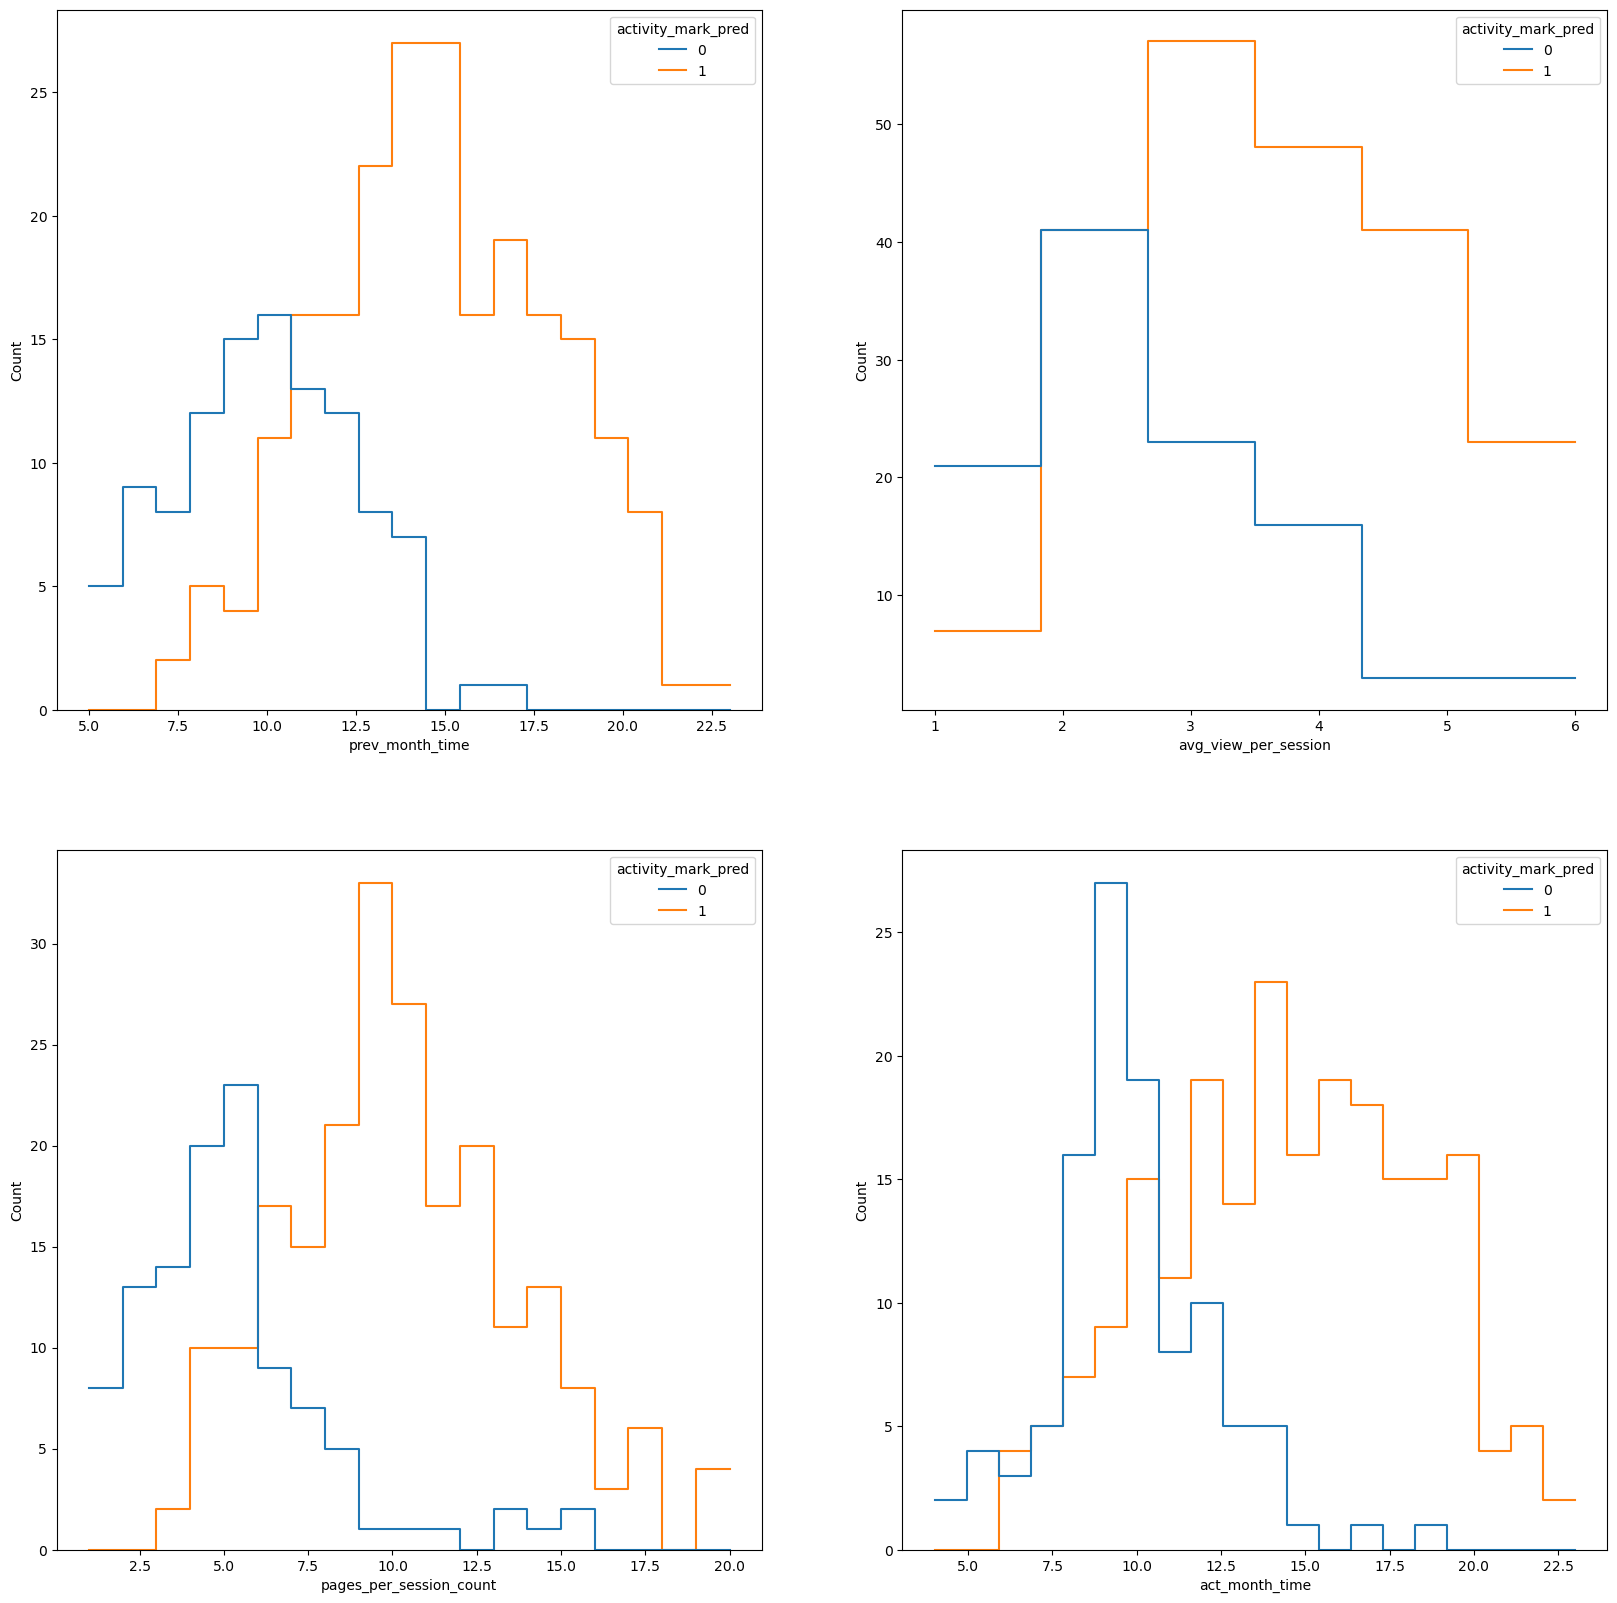

In [81]:
columns = [
    'prev_month_time',
    'avg_view_per_session',
    'pages_per_session_count',
    'act_month_time'
]

ncols = 2

nrows = np.ceil(
    np.divide(
        len(columns),
        ncols
        )
).astype('int')

plt.figure(figsize=(20, 20))

for n, col in enumerate(columns):
    ax = plt.subplot(nrows, ncols, n + 1)
    sns.histplot(
        x=final_df[col],
        bins=len(
            final_df[col].unique()
        ),
        element='step',
        fill=False,
        ax=ax,
        hue=final_df['activity_mark_pred']
    )

Очевидно, что чем больше пользователи проводят время на сайте, чем больше просматривают категорий за визит и чем больше просматривают страниц за визит, тем ниже вероятность их попадания в группу оттока.

<a id='section21'></a>
### Вывод

Согласие о получении дополнительных предложений о товаре `permission`, значение `Кухонная посуда` признака самой популярной категории товаров `popular_category` и количество маркетинговых коммуникаций в текущем месяце `market_com_cur_month` - наименее значимые для модели признаки. Сильнее всего на целевой признак влияют время, которое покупатель провел на сайте в предыдущем месяце `prev_month_time`, среднее количество просмотров категорий за визит `avg_view_per_session` и среднее количество просмотренных страниц за визит `pages_per_session_count`. Следовательно, маркетинговые активности должны быть направлены на увеличение значений этих признаков, например персонализированные email-рассылки на основе предпочтений клиента. Кроме того, сокращение значений этих признаков по всем клиентам в общем или по их сегментам - явный признак необходимости проведения подобных активностей или появления проблем, например, с отображением релевантого контента на сайте.

<a id='section22'></a>
## Сегментация покупателей

Для сегментации покупателей обогатим датафрейм `final_df` данными о среднемесячной прибыли каждого покупателя из датафрейма `profit`:

In [82]:
final_df = final_df.merge(
    profit,
    on='id',
    how='left'
)

Добавим в датафрейм вероятности принадлежности объектов классам:

In [83]:
final_df['activity_mark_proba'] = randomized_search.predict_proba(X_test)[:,1]

Отобразим первые 10 строк обновленного датафрейма:

In [84]:
final_df.head()

,id,service_type,permission,market_com_six_months,market_com_cur_month,duration,promo_purchases,popular_category,avg_view_per_session,unpaid_items,service_error_count,pages_per_session_count,prev_month_rev,month_before_prev_month_rev,act_month_rev,prev_month_time,act_month_time,activity_mark_pred,profit,activity_mark_proba
0,215439,True,False,3.40,5,448,0.28,Товары для детей,4,2,2,7,"5,484.00","4,551.00","5,833.70",9.00,9.00,0,6.33,0.26
1,216575,True,True,4.50,4,482,0.25,Косметика и аксесуары,3,2,2,9,"5,567.00","5,483.00","5,769.80",8.00,22.00,1,1.82,0.88
2,216411,False,True,5.10,4,602,0.23,Товары для детей,2,2,8,9,"4,857.00","4,775.00","4,915.50",17.00,15.00,1,3.26,0.79
3,215893,False,False,4.40,4,639,0.13,Мелкая бытовая техника и электроника,2,4,2,10,"4,936.50","5,016.00","4,997.60",22.00,14.00,1,3.16,0.96
4,215977,True,False,3.50,5,161,0.14,Кухонная посуда,2,1,5,8,"5,693.00","5,618.00","5,888.00",14.00,9.00,1,4.02,0.65


Визуализируем распределение клиентов по среднемесячной прибыли в зависимости от вероятности принадлежности объектов классам:

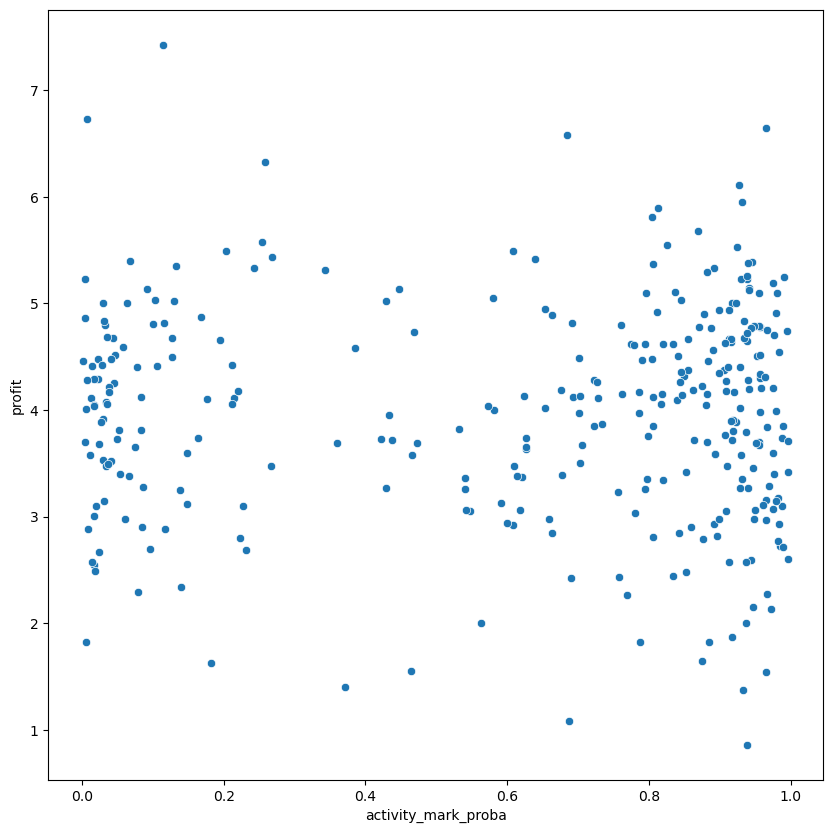

In [85]:
plt.figure(figsize=(10, 10))

sns.scatterplot(
    data=final_df,
    x='activity_mark_proba',
    y='profit'
)

plt.show()

Для анализа выберем семент высокодоходных покупателей, покупательская активность которых снизилась:

In [86]:
target_segment = final_df.query('profit >= 3 & activity_mark_proba <= 0.5')

Проанализируем изменение трат покупателей этого сегмента по категориям товаров:

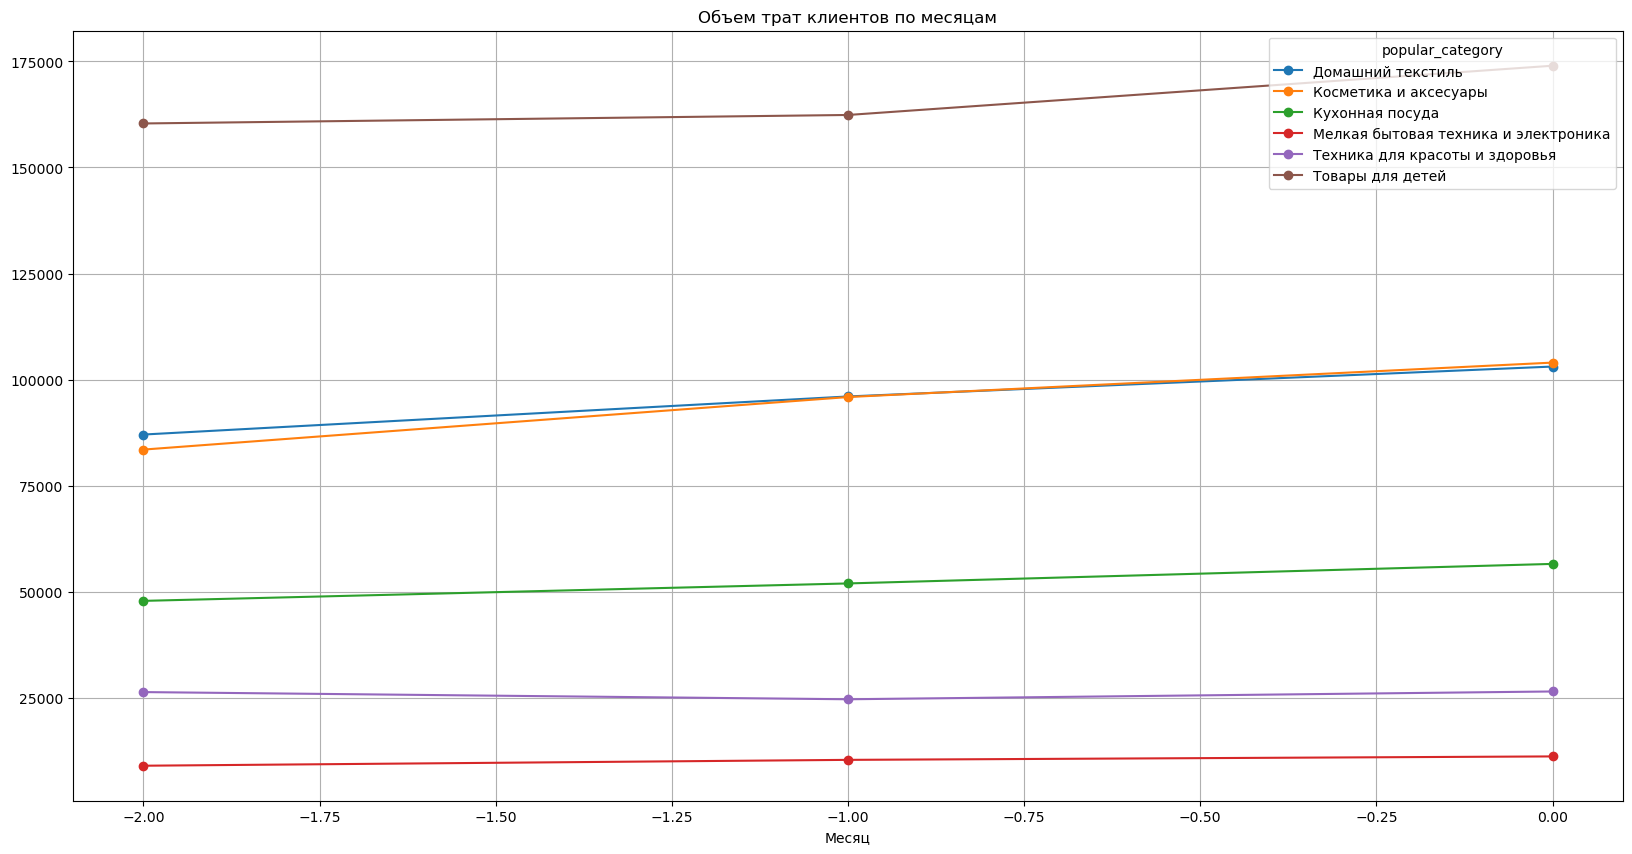

In [87]:
target_segment.rename(
    columns={
        'month_before_prev_month_rev' : -2,
        'prev_month_rev' : -1,
        'act_month_rev' : 0
    }
).melt(
    id_vars='popular_category',
    value_vars=[
        -2,
        -1,
        0
    ]
).pivot_table(
    index='variable',
    columns='popular_category',
    values='value',
    aggfunc='sum'  
).plot(
        #x='variable',
        kind='line',
        style='o-',
        grid='True',
        figsize=(20,10),
        title='Объем трат клиентов по месяцам',
        xlabel='Месяц'
    )

plt.show()

По графику очевидно, что наиболее популярными категориями, расходы на которые растут, у покупателей, активность которых снизилась, являются товары для детей, домашний текстиль и косметика. Такие товары покупаются регулярно. Следовательно, для удержания таких клиентов целесообразно проводить различные маркетинговые акциями по этим категориям товаров. Такими акциями могут быть распространение промокодов на эти категории товаров, увеличение размера скидки при увеличении количества товаров в корзине и другие аналогичные активности.  

<a id='section22'></a>
## Вывод

Опишем этапы проекта:
* задача проекта - используя данные модели и данные о прибыльности клиентов разработать решение, которое позволит увеличить покупательскую активность;
* исходные данные - датафреймы с данными о поведении покупателей на сайте, коммуникациях с покупателем и его продуктовом поведении, с данными по выручке с каждого покупателя, с данными о времени, которое покупатель провёл на сайте, с данными о среднемесячной прибыли покупателя за анализируемый период;
* в процессе предобработки данных скорректировали названия полей, выявили и исправили аномалии в категориальных переменных, скорректировали типы данных, убедились в отсутствии дубликатов, преобразовали значения времени и выручки для каждого периода в поля, и затем объединили данные;
* для поиска лучшей модели разработали пайплайн, для кодирования категориальных признаков использовали `OneHotEncoder` и `OrdianltEncoder`, для для масштабирования количественных - `StandardScaler()`, `MinMaxScaler()` и `RobustScaler()`, обучили четыре модели - `KNeighborsClassifier()`, `DecisionTreeClassifier()`, `LogisticRegression()` и `SVC()`, для оценки использовали метрику `ROC-AUC`;
* лучшей оказалась модель линейной регрессии со скалером `MinMaxScaler`;
* сегментировали покупателей по прибыльности и признаку активности, для анализа выбрали сегмент высокоприбыльных клиентов, активность которых снизилась;
* для повышения покупательской активности этого сегмента предложили регулярно проводить маркетинговые акции по категориям товаров, которые наиболее популярны у клиентов этого сегмента, и объемы покупок которых растут, кроме того, кажется целесообразным введение целевой программы лояльности для клиентов этого сегмента, например, фиксированная скидка на любые товары в зависимости от совокупного объема трат клиента, а также дополнительные скидки на категории товаров, которые такие покупатели обозначают как любимые. 